# Autoencoders (AEs) en MNIST

Para esta sección se trabaja con el dataset *MNIST*, el cual consta de imágenes de digitos del 0 al 9 escritos a mano y la tarea para la máquina de aprendizaje es de identificar qué digito está escrito en esa imagen, siendo un problema de clasificación con 10 clases. El dataset fue creado a partir del dataset *NIST*.  
Las imágenes son en un único canal (escala de grises) de 28 por 28 pixeles. El dataset consta de 60 mil ejemplos de entrenamiento y 10 mil ejemplos de pruebas.  
Se trabajará con autoencoders, los cuales son modelos de aprendizaje no supervisado, donde no se tienen datos etiquetados, es decir no se cuenta con un *target* y el objetivo es intentar detectar patrones relevantes en los datos.

In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu,floatX=float32,cuda.root=/usr/local/cuda-7.5/,optimizer=fast_compile" 

import theano
import keras
#print(theano.config)

from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D,UpSampling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils
from keras.utils import plot_model
from IPython.display import Image, display, SVG

import time
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import binomial
from numpy.random import standard_normal

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

Using TensorFlow backend.


En la celda anterior se importan todas las librerías a utilizar para el desarrollo de la actividad y se selecciona el dispositivo "gpu" para procesar todas las peticiones sobre la api de Keras.
Detalles técnicos son que se utilizó una tarjeta gráfica Nvidia GeForce 940M (GPU) en conjunto con la librería cuDNN version 5.1, para así agilizar los tiempos de ejecución comparados con procesarlos a través de la CPU.

### Cargar los datos

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

#Normalizacion
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#Flatten
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)

#validation data
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

print('Training set shape: ',x_train.shape)
print('Validation set shape: ',x_val.shape)
print('Test set shape: ',x_test.shape )

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

11444224/11490434 [============================>.] - ETA: 0s(60000, 28, 28)
(60000, 784)
('Training set shape: ', (55000, 784))
('Validation set shape: ', (5000, 784))
('Test set shape: ', (10000, 784))


En una primera instancia se cargan los datos a trabajar en esta sección, los cuales son proporcionado por la librería de keras *datasets*, los cuales son imágenes de MNIST, un canal de 28 por 28 pixeles. Definiendo un conjunto de validación como los últimos 5000 ejemplos del conjunto de entrenamiento. El conjunto de pruebas posee 10000 ejemplos.  
Se realiza un preprocesamiento a los datos antes de trabajarlos lo cual consta en normalizar, dejándolos en un intervalo entre 0 y 1, y transformar la imagen de 28 por 28 a un vector de 784 componentes.

In [3]:
#funcion utilizada para graficar el entrenamiento 
def plot_function(hist):
    loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(loss_values1) + 1)
    f, axarr = plt.subplots(1,figsize=(14,6))
    
    axarr.plot(epochs1, loss_values1, 'bo-', label = "Training set")
    axarr.plot(epochs1, val_loss_values1, 'g^-',label = "Val set")
    axarr.set_title('Loss Autoencoder')
    axarr.set_ylim(0,0.4)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    axarr.legend(loc="upper right", fancybox= True)

    plt.show()

## Reducir Dimensionalidad

### a) Entrenar un AE básico

In [21]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

Autoencoder


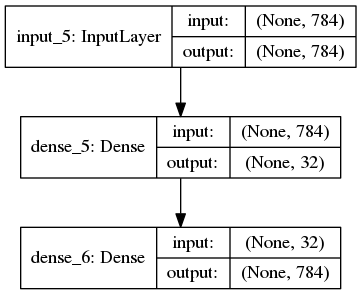

Encoder


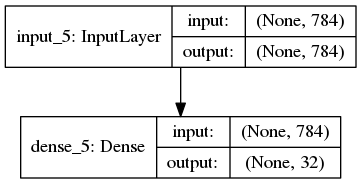

decoder


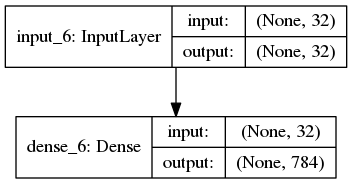

In [21]:
plot_model(autoencoder, to_file='aux.png', show_shapes=True)
print "Autoencoder"
display(Image(filename='aux.png') )

plot_model(encoder, to_file='aux.png', show_shapes=True)
print "Encoder"
display(Image(filename='aux.png') )

plot_model(decoder, to_file='aux.png', show_shapes=True)
print "decoder"
display(Image(filename='aux.png') )

En las celdas anteriores se define un Autoencoder básico, el cual tiene una capa escondida (*encoder*), visualizando en la imagen anterior lo que es el *encoder* (codificación del input), *decoder* (decodificación del input o reconstrucción del input) y Autoencoder (*encoder* + *decoder*). Mostrándo que la codificación es un vector de **32** componentes, es decir, el vector de **784** componentes es comprimido en tan solo 32. La función de activación seleccionada para la capa escondida (*encoder*) es la **sigmoidal**.  
Este es el objetivo de cuando se trabaja con autoencoder y lo que se intenta buscar en esta sección de la actividad, reducir la dimensionalidad a un vector de menor dimension que siga representando el input original, ya que existe una decodificación.

In [22]:
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True, validation_data=(x_val, x_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s - loss: 0.3044 - val_loss: 0.2683
Epoch 2/50
55000/55000 [==============================] - 5s - loss: 0.2664 - val_loss: 0.2653
Epoch 3/50
55000/55000 [==============================] - 5s - loss: 0.2647 - val_loss: 0.2644
Epoch 4/50
55000/55000 [==============================] - 5s - loss: 0.2641 - val_loss: 0.2640
Epoch 5/50
55000/55000 [==============================] - 5s - loss: 0.2638 - val_loss: 0.2637
Epoch 6/50
55000/55000 [==============================] - 5s - loss: 0.2635 - val_loss: 0.2635
Epoch 7/50
55000/55000 [==============================] - 5s - loss: 0.2630 - val_loss: 0.2623
Epoch 8/50
55000/55000 [==============================] - 6s - loss: 0.2614 - val_loss: 0.2607
Epoch 9/50
55000/55000 [==============================] - 7s - loss: 0.2598 - val_loss: 0.2591
Epoch 10/50
55000/55000 [==============================] - 7s - loss: 0.2578 - val_loss: 0.2566


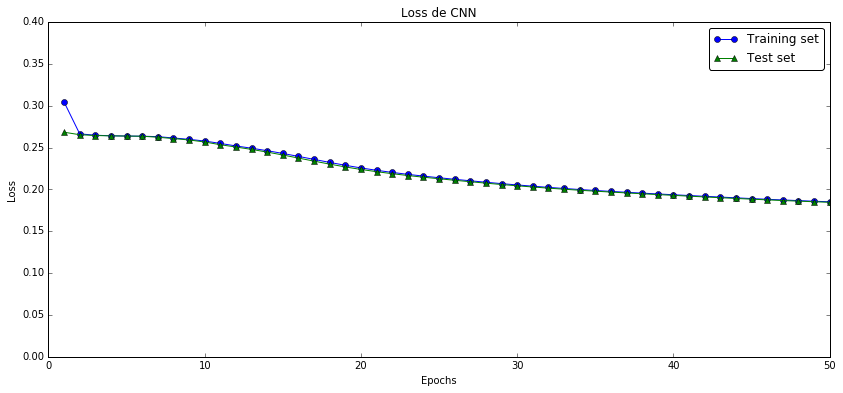

In [23]:
plot_function(hist.history)

En las celdas anteriores se entrena el autoencoder definido anteriormente a través del optimizador conocido en la tarea 1 **SGD** con tasa de aprendizaje 1 y función de pérdida por defecto para autoencoders *binary cross-entropy*, esta función es requerida ya que la salida de la red (input reconstruido) se modela como que cada componente es independiente del resto, ya que se desea reconstruir cada componente por separado.  
El gráfico anterior resume el entrenamiento del modelo propuesto, es decir, cómo varía la función de pérdida (*loss*) en función del número de epochs, mostrándo que es bastante bajo (entre 0.2 y 0.3), además de disminuir constantemente en cada epoch. Esta función de pérdida representa el error de reconstruir el input original.

#### Cambiar a Relu

In [24]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

En la celda anterior se vuelve a definir el modelo de autoencoder básico, cambiando la función de activación en el *encoder* (capa oculta) por una **relu**, para así verificar cual modelo tiene un mejor desempeño para este problema.

In [25]:
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True, validation_data=(x_val, x_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s - loss: 0.2333 - val_loss: 0.1799
Epoch 2/50
55000/55000 [==============================] - 6s - loss: 0.1628 - val_loss: 0.1472
Epoch 3/50
55000/55000 [==============================] - 6s - loss: 0.1380 - val_loss: 0.1296
Epoch 4/50
55000/55000 [==============================] - 6s - loss: 0.1232 - val_loss: 0.1179
Epoch 5/50
55000/55000 [==============================] - 6s - loss: 0.1139 - val_loss: 0.1112
Epoch 6/50
55000/55000 [==============================] - 6s - loss: 0.1084 - val_loss: 0.1068
Epoch 7/50
55000/55000 [==============================] - 6s - loss: 0.1049 - val_loss: 0.1041
Epoch 8/50
55000/55000 [==============================] - 6s - loss: 0.1027 - val_loss: 0.1023
Epoch 9/50
55000/55000 [==============================] - 6s - loss: 0.1011 - val_loss: 0.1011
Epoch 10/50
55000/55000 [==============================] - 6s - loss: 0.1001 - val_loss: 0.1001


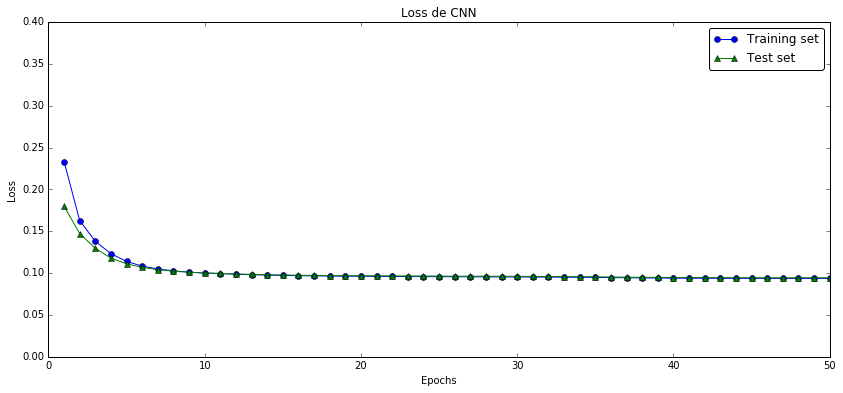

In [26]:
plot_function(hist.history)

En las celdas anterior se entrena el autoencoder de la misma forma que con el modelo con sigmoidal, presentándo su resumen en el gráfico anterior. Se observa que este modelo se comporta mucho mejor que con sigmoidal, ya que el error de reconstrucción (*loss*) es mucho menor, llegando a 0.10 luego de 10 epochs, además de que disminuye con una intensidad mayor (exponencialmente), por lo que experimentalmente se encuentra que para este caso el espacio de búsqueda que genera el modelo con función de activación **relu** es mucho más facil de tratar y encontrar un mejor óptimo que el modelo anterior.  
Se tiene que la función de activación **relu** permite una representación en dominio mas libre (todos los positivos y el cero), que la **sigmoidal** (entre 0 y 1), además de ofrecer una representación claramente dispersa ya que para valores negativos de dominio entrega un valor cero, caso que no sucede con **sigmoidal**, el cual con valores muy negativos entrega valor cercano a cero.  
Otro problema presenta utilizar función de activación **relu** en el decoder es que el gradiente del error de reconstrucción es cero para todo los negativos en la entrada de la función **relu**, por lo que los pesos no se actualizan.  

Dato relevante es que estos modelos entrenados no producen **overfitting** a ningún nivel, incluso en los primeros epochs se tiene un *underfitting*, generando un modelo bastante general sobre la data de entrenamiento. Esto es explicado ya que como este no es un problema supervisado, es decir, no se está intentando de encontrar un modelo que prediga algún fenómeno en específico en base a los datos, sino que es un problema **no supervisado** donde la tarea del modelo es reconstruir el input original comprimido desde un espacio dimensional menor, por lo que en ese espacio dimensional (manifold) debe extraer características relevantes de la data, reconociendo patrones que logren distinguir y que sean únicos de los datos con los que se trabaja.

In [5]:
dimensiones = [2,8,32,64]
historiales = []

for d in dimensiones:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True, validation_data=(x_val, x_val))
    historiales.append(hist)
    autoencoder.save('./modelos_entrenados/basic_autoencoder_768x'+str(d)+'.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 5s - loss: 0.2812 - val_loss: 0.2517
Epoch 2/50
55000/55000 [==============================] - 5s - loss: 0.2498 - val_loss: 0.2479
Epoch 3/50
55000/55000 [==============================] - 5s - loss: 0.2461 - val_loss: 0.2450
Epoch 4/50
55000/55000 [==============================] - 5s - loss: 0.2432 - val_loss: 0.2427
Epoch 5/50
55000/55000 [==============================] - 5s - loss: 0.2414 - val_loss: 0.2413
Epoch 6/50
55000/55000 [==============================] - 5s - loss: 0.2404 - val_loss: 0.2407
Epoch 7/50
55000/55000 [==============================] - 5s - loss: 0.2399 - val_loss: 0.2402
Epoch 8/50
55000/55000 [==============================] - 5s - loss: 0.2394 - val_loss: 0.2397
Epoch 9/50
55000/55000 [==============================] - 5s - loss: 0.2390 - val_loss: 0.2394
Epoch 10/50
55000/55000 [==============================] - 6s - loss: 0.2387 - val_loss: 0.2391


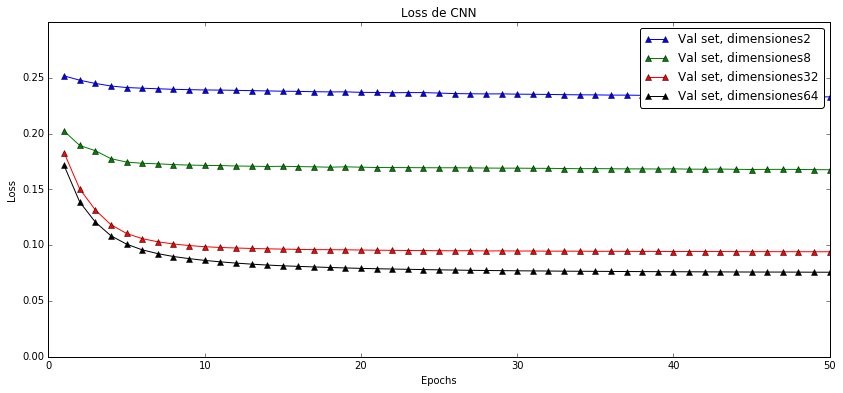

In [14]:
f, axarr = plt.subplots(1,figsize=(14,6))
colores = ['b','g','r','k']

for histori,col,d in zip(historiales,colores,dimensiones): #para cada dimension
    
    hist = histori.history
    #loss_values1 = hist['loss']
    val_loss_values1 = hist['val_loss']
    epochs1 = range(1, len(val_loss_values1) + 1)

    #axarr.plot(epochs1, loss_values1, col+'o-', label = "Training set, dimensiones"+str(d))
    axarr.plot(epochs1, val_loss_values1, col+'^-',label = "Val set, dimensiones"+str(d))
    axarr.set_title('Loss Autoencoder')
    axarr.set_ylim(0,0.3)
    axarr.set_xlabel('Epochs')
    axarr.set_ylabel('Loss')
    
    axarr.legend(loc="upper right", fancybox= True)
plt.show()

En las celdas anterior se entrenan autoencoder con función de activación relu, con distinto número de neuronas en la capa oculta (dimensiones de la codificación o proyección), mostrándo en el gráfico un resumen de esto, visualizando el error sobre el conjunto de validación unicamente para una claridad visual mayor ya que se sobrelapan, debido a lo anteriormente comentado, que los errores de validación y de entrenamiento son bastante similares.  
La compresión que logra cada dimensión respecto al input original (784 componentes) es 99,7% para 2 dimensiones, 99,0% para 8 dimensiones, 95,9% para 32 dimensiones y 91,8% para 64 dimensiones, por lo que se puede ver en porcentaje que la compresión es bastante alta, mayor al 90% en los 4 casos presentados, teniendo un significado de que el autoencoder comprime en un 90% toda la información entregada en 784 componentes a una mas reducida.  
Se puede ver que al ir aumentando el número de componentes en el vector codificado el error de reconstruir el input disminuye, es decir, es mas facil reconstruir el input desde un espacio con mayor dimensiones ya que así permite extraer más patrones relevantes de los datos. Por ejemplo con 2 dimensiones es bastante dificil reconstruir un vector de 784 dimensiones, por otro lado, con más de 32 dimensiones se hace mas sencillo reconstruir el vector original de 784 dimensiones.  

Utilizar función de activación relu en el decoder (capa de salida u output) no es recomendado ya que el error obtenido es bastante alto. Esto es ya que como cada componente del vector de entrada está en un intervalo entre 0 y 1, es mas recomendable utilizar una función de activación que tiene su imagen en un intervalo entre 0 y 1 también, asi la reconstrucción se facilita. Por otro lado se tiene que la imagen de la función relu son todos lo números positivos y el cero.

### b) Visualmente reconstrucción autoencoder

Para 2 dimensiones en el encoded (compresion)


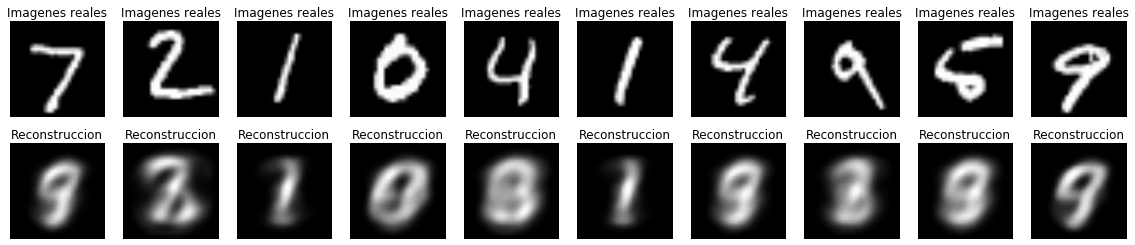

Para 8 dimensiones en el encoded (compresion)


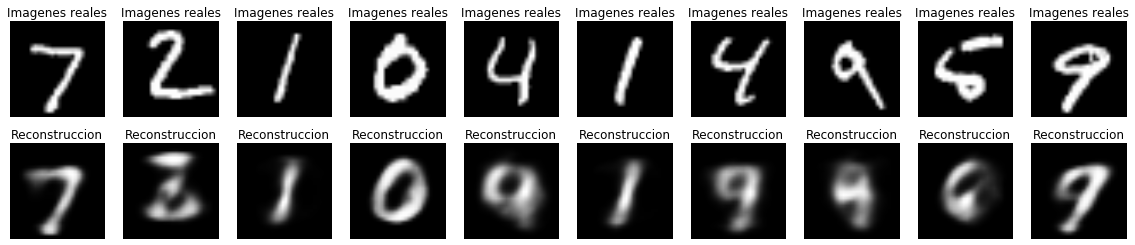

Para 32 dimensiones en el encoded (compresion)


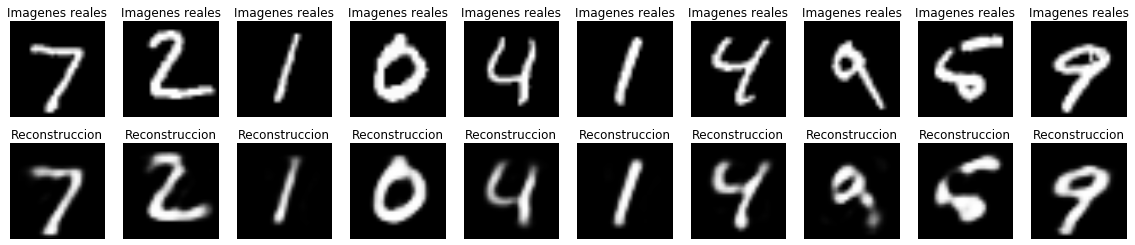

Para 64 dimensiones en el encoded (compresion)


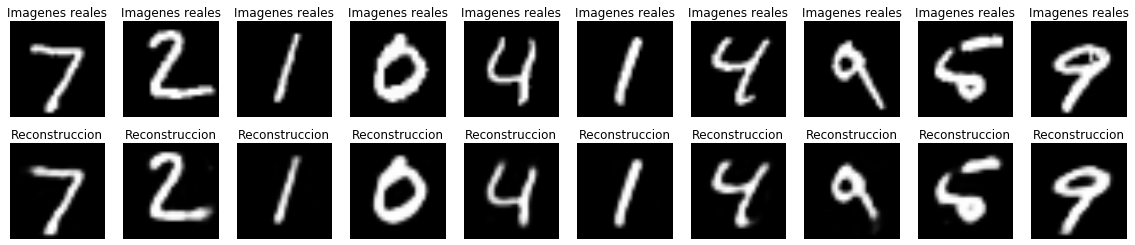

In [58]:
for d in dimensiones:
    print "Para "+ str(d)+" dimensiones en el encoded (compresion)"
    autoencoder = load_model('./modelos_entrenados/basic_autoencoder_768x'+str(d)+'.h5')
    
    #Reconstruir los encoder y decoder desde el autoencoder
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
   
    decoded_shape = Input(shape=(d,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

    
    encoded_test = encoder.predict(x_test)
    decoded_test = decoder.predict(encoded_test)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Imagenes reales")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruccion")
    plt.show()

En esta celda se visualiza la reconstrucción generada por cada modelo con distintas dimensiones en el *encoded* (2, 8, 32, 64), el cual está bastante asociado al error de reconstrucción ya que con menos dimensiones en la representación codificada la reconstrucción es peor, siendo mas borrosa como se muestra con 2 y 8 dimensiones, además de que la forma del número en la imagen reconstruida tampoco es la correcta con la imagen real.  
Cuando el número de dimensiones en el *encoded* aumenta consisderablemente (32 y 64) se tiene una reconstrucción mucho mas clara, donde con 64 dimensiones es bastante igual a la real. Por otro lado, la reconstrucción con 32 dimensiones es un poco difusa.  
Esto es correspondido a los gráficos de error de reconstrucción mostrados anteriormente donde para las dimensiones 32 y 64 están bastantes alejados de 2 y 8.

### c) Evaluación 

In [6]:
start_time = time.time()
clf = KNeighborsClassifier(10)
clf.fit(x_train, Y_train)
print 'Classification Accuracy sobre Data original %.2f' % clf.score(x_test,Y_test)
print("--- %s seconds ---" % (time.time() - start_time))

dimensiones = [2,8,32,64]
for d in dimensiones:
    print "Para "+ str(d)+" dimensiones"
    autoencoder = load_model('./modelos_entrenados/basic_autoencoder_768x'+str(d)+'.h5')
    
    #Reconstruir los encoder y decoder desde el autoencoder
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    
    start_time = time.time()
    encoded_test = encoder.predict(x_test)
    encoded_train = encoder.predict(x_train)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print 'Classification Accuracy sobre Data reducida %.2f' % clf.score(encoded_test,Y_test)
    print("--- %s seconds ---" % (time.time() - start_time))

Classification Accuracy sobre Data original 0.95
--- 921.681766033 seconds ---
Para 2 dimensiones
Classification Accuracy sobre Data reducida 0.17
--- 0.794321060181 seconds ---
Para 8 dimensiones
Classification Accuracy sobre Data reducida 0.86
--- 1.81898999214 seconds ---
Para 32 dimensiones
Classification Accuracy sobre Data reducida 0.96
--- 37.0646340847 seconds ---
Para 64 dimensiones
Classification Accuracy sobre Data reducida 0.95
--- 72.7336640358 seconds ---


En esta celda se verifica la calidad de la representación obtenida (codificación) a distintas dimensiones, en base al *accuracy* obtenido mediante el clasificador k-NN para predecir la etiqueta correcta del número escrito en la imagen, en base a los *k* vecinos mas cercanos medido con distancia euclideana, entrenando con el conjunto de entrenamiento y evaluando sobre el conjunto de pruebas.  
Se puede ver que el *accuracy* sobre la representación original, vectores de 784  componentes, tiene un valor bastante alto de 95%, asociado a un tiempo de ejecución muy alto comparado con la representación reducida. Además de que la representación reducida con 32 o 64 dimensiones logra superar el *accuracy* alcanzado por la representación original teniendo un tiempo de ejecución mucho menor.  
Con esto se puede ver que la elección de realizar una reducción de dimensionalidad a través de los autoencoder puede ser bastante útil ya que se alcanza el mismo *accuracy*, o mayor, que sobre la data en su forma original con un tiempo de ejecución mucho menor.

### d) Comparar con PCA

In [11]:
dimensiones = [2,4,8,16,32]

for d in dimensiones:
    input_img = Input(shape=(784,))
    encoded = Dense(d, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,shuffle=True, validation_data=(x_val, x_val),verbose=0)
    autoencoder.save('./modelos_entrenados/basic_autoencoder_768x'+str(d)+'.h5')

En la celda anterior se entrenan autoencoder básicos con distinto números de dimensiones en el *encoder* (codificación), guardando el modelo entrenado en un archivo comprimido binario de tipo HDF5.

In [16]:
for d in dimensiones:
    print "-------- Para "+ str(d)+" dimensiones ---------"
    autoencoder = load_model('./modelos_entrenados/basic_autoencoder_768x'+str(d)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    
    print "\n Error de reconstruccion para Encoder = ", score

    start_time = time.time()

    #Reconstruir los encoder desde el autoencoder
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))
    
    encoded_test = encoder.predict(x_test)
    encoded_train = encoder.predict(x_train)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print 'Encoder Accuracy  = %.2f (on %f seconds)' %( clf.score(encoded_test,Y_test), (time.time() - start_time))

    start_time = time.time()

    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, Y_train)
    print 'PCA Accuracy = %.2f (on %f seconds)' % (clf.score(pca_test,Y_test) , (time.time() - start_time) )

-------- Para 2 dimensiones ---------
 9600/10000 [===========================>..] - ETA: 0s
 Error de reconstruccion para Encoder =  0.229694300938
Encoder Accuracy  = 0.19 (on 0.733054 seconds)
PCA Accuracy = 0.26 (on 3.041792 seconds)
-------- Para 4 dimensiones ---------
 9536/10000 [===========================>..] - ETA: 0s
 Error de reconstruccion para Encoder =  0.202378201103
Encoder Accuracy  = 0.48 (on 0.754346 seconds)
PCA Accuracy = 0.51 (on 3.322290 seconds)
-------- Para 8 dimensiones ---------
 9248/10000 [==========================>...] - ETA: 0s
 Error de reconstruccion para Encoder =  0.16648657937
Encoder Accuracy  = 0.87 (on 1.631313 seconds)
PCA Accuracy = 0.88 (on 4.763506 seconds)
-------- Para 16 dimensiones ---------
 9184/10000 [==========================>...] - ETA: 0s
 Error de reconstruccion para Encoder =  0.127472727489
Encoder Accuracy  = 0.94 (on 7.441271 seconds)
PCA Accuracy = 0.95 (on 12.941414 seconds)
-------- Para 32 dimensiones ---------
 9536/10

Como ya se comprobó anteriormente que el proyectar la data original en un subespacio menor (reducción de dimensionalidad) es mejor que trabajar sobre la data original para este caso, se compara el autoencoder con el clásico modelo de reducción de dimensionalidad PCA. Para esto se compara la métrica de *accuracy*, con el clasificador k-NN descrito anteriormente, sobre distinto número de dimensiones en el subespacio de reducción.  
Para cada una de las 5 distintas dimensiones en la representación reducida, el autoencoder tiene un peor desempeño que PCA, exceptuando con 32 dimensiones donde igualan en *accuracy*. El tiempo de ejecución del autoencoder es menor que PCA en todos los casos exceptuando al de 32 dimensiones.  

Estos resultados muestran que esta técnica clasica de reducción de dimensionalidad (PCA) logra comprimir la información de los datos en un subespacio que beneficia a la tarea de etiquetar al número en la imagen en comparación al autoencoder, ya que quizas el modelo planteado del autoencoder con una capa oculta y sin ninguna penalización es muy simple para superar a la técnica PCA.

### f) Deep autoencoder 

Como se vió que un autoencoder simple con una capa oculta no logra superar el desempeño de PCA en etiquetar correctamente, se trabaja con un *deep autoencoder* el cual intenta comprimir la información pasando por un mayor número de capas escondidas, esperando que se logre extraer información mas relevante del input, en donde el encoder tiene la siguiente estructura a distintas profundidades:

|modelo\capas | L=1 | L=2 | L=3 | L=4 | L=5 |
|-------|-----|-----|-----|-----|-----|
|2 capas escondidas| input | 1000 | target dim| | |
|3 capas escondidas | input | 1000 | 500 | target dim| |
|4 capas escondidas |input | 1000 | 500| 250 | target dim|

#### 2 capas

In [10]:
#entrenar red
dimensiones = [2,4,8,16,32]
historiales = []

for d in dimensiones:
    target_dim = d #try other and do a nice plot
    input_img = Input(shape=(784,))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(target_dim, activation='relu')(encoded1)
    decoded2 = Dense(1000, activation='relu')(encoded2)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    encoder = Model(inputs=input_img, outputs=encoded2)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,shuffle=True,validation_data=(x_val, x_val))
    historiales.append(hist.history)
    autoencoder.save('./modelos_entrenados/my_autoencoder_768x1000x'+str(d)+'.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 24s - loss: 0.2579 - val_loss: 0.2367
Epoch 2/40
55000/55000 [==============================] - 25s - loss: 0.2330 - val_loss: 0.2302
Epoch 3/40
55000/55000 [==============================] - 23s - loss: 0.2270 - val_loss: 0.2245
Epoch 4/40
55000/55000 [==============================] - 25s - loss: 0.2216 - val_loss: 0.2198
Epoch 5/40
55000/55000 [==============================] - 25s - loss: 0.2180 - val_loss: 0.2169
Epoch 6/40
55000/55000 [==============================] - 26s - loss: 0.2157 - val_loss: 0.2145
Epoch 7/40
55000/55000 [==============================] - 25s - loss: 0.2140 - val_loss: 0.2130
Epoch 8/40
55000/55000 [==============================] - 27s - loss: 0.2125 - val_loss: 0.2119
Epoch 9/40
55000/55000 [==============================] - 25s - loss: 0.2114 - val_loss: 0.2108
Epoch 10/40
55000/55000 [==============================] - 26s - loss: 0.2103 - val_los

#### 3 capas

In [11]:
historiales2 = []
for d in dimensiones:
    target_dim = d #try other and do a nice plot
    input_img = Input(shape=(784,))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(target_dim, activation='relu')(encoded2)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    encoder = Model(inputs=input_img, outputs=encoded3)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,shuffle=True,validation_data=(x_val, x_val))
    historiales2.append(hist.history)
    autoencoder.save('./modelos_entrenados/my_autoencoder_768x1000x500x'+str(d)+'.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 33s - loss: 0.2926 - val_loss: 0.2633
Epoch 2/40
55000/55000 [==============================] - 33s - loss: 0.2633 - val_loss: 0.2637
Epoch 3/40
55000/55000 [==============================] - 33s - loss: 0.2632 - val_loss: 0.2632
Epoch 4/40
55000/55000 [==============================] - 33s - loss: 0.2632 - val_loss: 0.2633
Epoch 5/40
55000/55000 [==============================] - 33s - loss: 0.2632 - val_loss: 0.2634
Epoch 6/40
55000/55000 [==============================] - 33s - loss: 0.2632 - val_loss: 0.2632
Epoch 7/40
55000/55000 [==============================] - 33s - loss: 0.2632 - val_loss: 0.2633
Epoch 8/40
55000/55000 [==============================] - 33s - loss: 0.2589 - val_loss: 0.2417
Epoch 9/40
55000/55000 [==============================] - 33s - loss: 0.2382 - val_loss: 0.2354
Epoch 10/40
55000/55000 [==============================] - 33s - loss: 0.2346 - val_los

#### 4 capas

In [37]:
historiales3 = []
for d in dimensiones:
    target_dim = d #try other and do a nice plot
    input_img = Input(shape=(784,))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(target_dim, activation='relu')(encoded3)
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(decoded4)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(inputs=input_img, outputs=decoded1)
    encoder = Model(inputs=input_img, outputs=encoded4)
    
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,shuffle=True,validation_data=(x_val, x_val))
    historiales3.append(hist.history)
    autoencoder.save('./modelos_entrenados/my_autoencoder_768x1000x500x250x'+str(d)+'.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 45s - loss: 0.2663 - val_loss: 0.2480
Epoch 2/40
55000/55000 [==============================] - 43s - loss: 0.2429 - val_loss: 0.2402
Epoch 3/40
55000/55000 [==============================] - 45s - loss: 0.2305 - val_loss: 0.2204
Epoch 4/40
55000/55000 [==============================] - 45s - loss: 0.2145 - val_loss: 0.2087
Epoch 5/40
55000/55000 [==============================] - 45s - loss: 0.2063 - val_loss: 0.2030
Epoch 6/40
55000/55000 [==============================] - 46s - loss: 0.2008 - val_loss: 0.1994
Epoch 7/40
55000/55000 [==============================] - 43s - loss: 0.1966 - val_loss: 0.1936
Epoch 8/40
55000/55000 [==============================] - 41s - loss: 0.1938 - val_loss: 0.1922
Epoch 9/40
55000/55000 [==============================] - 41s - loss: 0.1915 - val_loss: 0.1882
Epoch 10/40
55000/55000 [==============================] - 41s - loss: 0.1895 - val_los

Los 3 modelos con distinto número de capas ocultas son entrenados en las celdas anteriores con el mismo método que los modelos anteriores, además de almacenar estos en un archivo *.h5*. El tiempo de ejecución es similar para las distintas profunidades de la red, puesto que este es un modelo bastante simple.

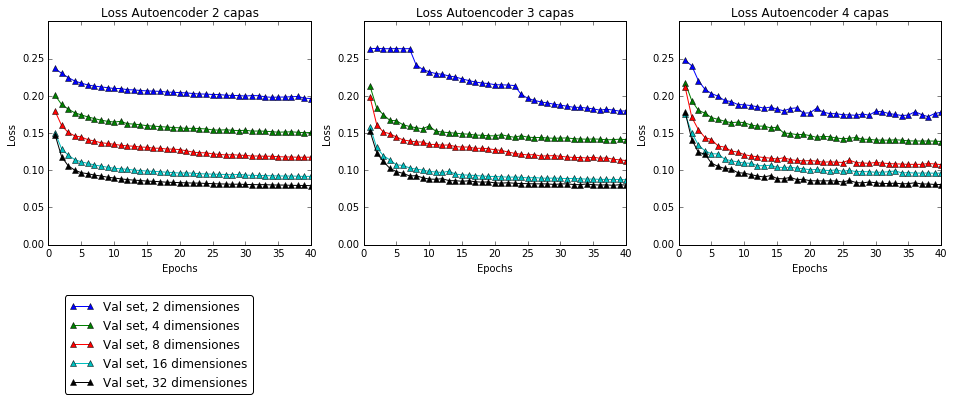

In [48]:
#plot de los 3 historiales...
resumen = [historiales,historiales2,historiales3]

f, axarr = plt.subplots(1,3, figsize=(16,4))
for histo,i in zip(resumen,range(3)): #para cada profundiad
    colores = ['b','g','r','c','k']

    for hist,col,d in zip(histo,colores,dimensiones): #para cada dimension
        val_loss_values1 = hist['val_loss']
        epochs1 = range(1, len(val_loss_values1) + 1)

        #axarr.plot(epochs1, loss_values1, col+'o-', label = "Training set, dimensiones"+str(d))
        axarr[i].plot(epochs1, val_loss_values1, col+'^-',label = "Val set, "+str(d)+ " dimensiones")
        axarr[i].set_title('Loss Autoencoder '+str(i+2)+ ' capas')
        axarr[i].set_ylim(0,0.3)
        axarr[i].set_xlabel('Epochs')
        axarr[i].set_ylabel('Loss')

axarr[0].legend(loc="upper right", fancybox= True,bbox_to_anchor=(.8,-.2))
plt.show()

Los gráficos anteriores resumen el entrenamiento durante 40 epochs, donde el eje *y* es la función de pérdida asignada en el modelo (*binary cross-entropy*) y que solo se presenta sobre el conjunto de validación debido a lo anteriormente comentado de que se sobrelapan.  
Se puede ver, que para 2 dimensiones, la función de pérdida se comporta extraña al aumentar la profundidad en el autoencoder, teniendo saltos bastante inesperados en su entrenamiento. Por otro lado para mayor dimensiones la función de pérdida no parece sufrir un notorio cambio más que con 3 capas ocultas y 16 dimensiones tiene una pérdida menor y muy cercana a con 32 dimensiones.  
Otro elemento particular que se observa en los gráficos es que a una mayor profundidad en la red de autoencoder, el entrenamiento comienza con una pérdida mayor, pudiendo ser explicado debido a que existe una mayor cantidad de parámetros que deben ser entrenados en la red y la inicialización es crucial para esto.

In [46]:
for d in dimensiones:
    print "\n-------- Para "+ str(d)+" dimensiones ---------"
    
    #PCA
    start_time = time.time()

    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, Y_train)
    print '>> PCA Accuracy = %.2f (on %f seconds)' % (clf.score(pca_test,Y_test) , (time.time() - start_time) )
    
    ##AUTOENCODERS
    print ">> con 2 capas"
    autoencoder = load_model('./modelos_entrenados/my_autoencoder_768x1000x'+str(d)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    
    print "\nError de reconstruccion para Encoder = ", score

    start_time = time.time()

    #Reconstruir 
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-3]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-4].output))
    
    encoded_test = encoder.predict(x_test)
    encoded_train = encoder.predict(x_train)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print 'Encoder Accuracy  = %.2f (on %f seconds)' %( clf.score(encoded_test,Y_test), (time.time() - start_time))
    
    print ">> con 3 capas"
    autoencoder = load_model('./modelos_entrenados/my_autoencoder_768x1000x500x'+str(d)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    
    print "\nError de reconstruccion para Encoder = ", score

    start_time = time.time()

    #Reconstruir 
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-4]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-5].output))
    
    encoded_test = encoder.predict(x_test)
    encoded_train = encoder.predict(x_train)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print 'Encoder Accuracy  = %.2f (on %f seconds)' %( clf.score(encoded_test,Y_test), (time.time() - start_time))

    print ">> con 4 capas"
    autoencoder = load_model('./modelos_entrenados/my_autoencoder_768x1000x500x250x'+str(d)+'.h5')
    score = autoencoder.evaluate(x_test,x_test)
    
    print "\n Error de reconstruccion para Encoder = ", score

    start_time = time.time()

    #Reconstruir 
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-5]
    encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-6].output))
    
    encoded_test = encoder.predict(x_test)
    encoded_train = encoder.predict(x_train)
    
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print 'Encoder Accuracy  = %.2f (on %f seconds)' %( clf.score(encoded_test,Y_test), (time.time() - start_time))


-------- Para 2 dimensiones ---------
>> PCA Accuracy = 0.26 (on 3.152261 seconds)
>> con 2 capas
 9696/10000 [============================>.] - ETA: 0s
Error de reconstruccion para Encoder =  0.196872045135
Encoder Accuracy  = 0.44 (on 2.198655 seconds)
>> con 3 capas
 9728/10000 [============================>.] - ETA: 0s
Error de reconstruccion para Encoder =  0.181339846849
Encoder Accuracy  = 0.63 (on 3.049228 seconds)
>> con 4 capas
 9824/10000 [============================>.] - ETA: 0s
 Error de reconstruccion para Encoder =  0.178571940684
Encoder Accuracy  = 0.69 (on 3.919493 seconds)

-------- Para 4 dimensiones ---------
>> PCA Accuracy = 0.51 (on 3.315975 seconds)
>> con 2 capas
 9760/10000 [============================>.] - ETA: 0s
Error de reconstruccion para Encoder =  0.152360824347
Encoder Accuracy  = 0.81 (on 3.252007 seconds)
>> con 3 capas
 9536/10000 [===========================>..] - ETA: 0s
Error de reconstruccion para Encoder =  0.142636453938
Encoder Accuracy  

En las celdas anteriores se presenta el *accuracy* sobre el conjunto de pruebas obtenido mediante el clasificador k-NN para distintas dimensiones en la representación reducida, comparando PCA con los autoencoder a distintas profundidades.  
En los resultados presentados se encuentra que para las 3 profundidades entrenadas en el autoencoder se llega a un *accuracy* mejor que con PCA, siendo bastante superior en la representación reducida con 2 y 4 dimensiones, esto es ya que el autoencoder profundo logra extraer información más relevante que PCA, es decir, comprime los datos en una representación (subespacio) que logra identificar de mejor manera que PCA las distintas clases a las que pertenecen los ejemplos.  
Otro resultado presentado es que a una mayor profundidad en la red del autoencoder se encuentra con mejores desempeños sobre la clasificación via k-NN. Esto es ya que al tener una red más profunda en el autoencoder, al igual que para problemas supervisados, se posee un mayor poder de interpretación de los datos, pudiendo extraer información más relevante de los datos en cada capa.  

Los tiempos de ejecución de autoencoder no incluye el entrenamiento, por lo que estos son mucho mayores que PCA, ya que el tiempo de ejecución presentado para PCA incluye el método de entrenamiento *fit*. Los tiempos de entrenamiento de los autoencoder son desde 80 hasta 160 segundos para el autoencoder de 4 capas.

### g) Visualizar representacion en 2d (TSNE)

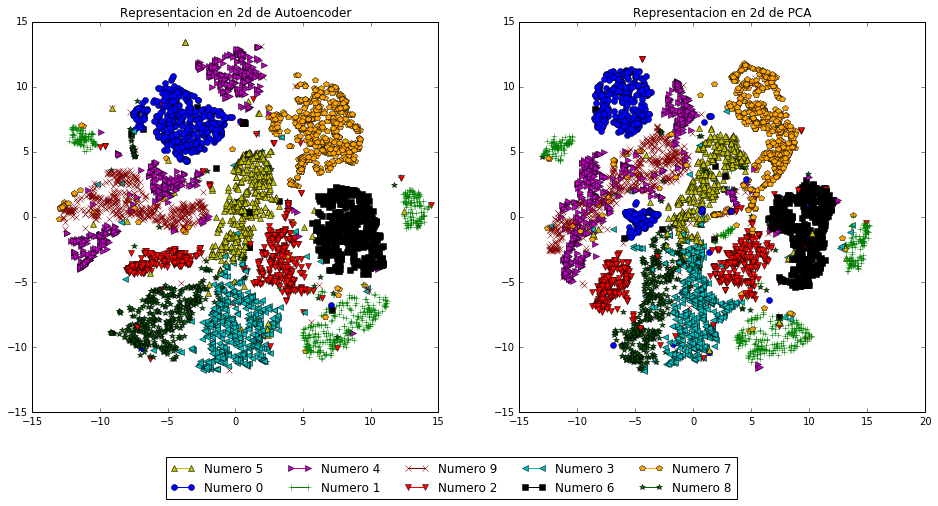

In [3]:
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
labels = range(10)

nplot=5000 #warning: mind your memory!

d = 16 #dimension de la representacion latente del input (encoder)

#load best model
autoencoder = load_model('./modelos_entrenados/my_autoencoder_768x1000x500x'+str(d)+'.h5')
#Reconstruir 
input_img = autoencoder.input
encoder_layer = autoencoder.layers[-4]
encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-5].output))

encoded_train = encoder.predict(x_train[:nplot])

model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)

f, axarr = plt.subplots(1,2, figsize=(16,7))

for idx in xrange(0,nplot):
    labelx = y_train[idx]
    if labelx in labels: #para agregar label
        line = axarr[0].plot(encoded_train[idx][0], encoded_train[idx][1],
                   color=colors[labelx], marker=markers[labelx], markersize=6, label = "Numero "+str(labelx))
        labels.remove(labelx)
    else:
        line = axarr[0].plot(encoded_train[idx][0], encoded_train[idx][1],
                   color=colors[labelx], marker=markers[labelx], markersize=6)
axarr[0].set_title("Representacion en 2d de Autoencoder")
axarr[0].legend(bbox_to_anchor=(1.75, -0.1),ncol=5)

#PARA PCA
pca = PCA(n_components=d)
pca.fit(x_train)
encoded_train = pca.transform(x_train[:nplot])

model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)

for idx in xrange(0,nplot):
    label = y_train[idx]
    line = axarr[1].plot(encoded_train[idx][0], encoded_train[idx][1],
                    color=colors[label], marker=markers[label], markersize=6)
axarr[1].set_title("Representacion en 2d de PCA")
plt.show()

En el gráfico anterior se visualiza las representaciones codificadas con el autoencoder a y PCA a 16 dimensiones, a través del *embedding* t-SNE. Con cada color y figura asociado a la etiqueta en específico de cada ejemplo, pudiendo ver que estos están agrupados en clusters gracias a la codificación de ambos modelos donde extraen características relevantes de los datos en cada componente, pudiendo así agrupar en base a estas características de mas alto nivel.  
Se puede ver que la representación codificada del autoencoder deja los cluster más distantes entre sí, teniendo una frontera clara entre ellos, además de que agrupa todos los 0 juntos comparado con PCA, además de que los 7 y los 6 quedan agrupados de una forma redonda más simétrica, los 8 son mejor separados del número 3 con el autoencoder. Visualmente se puede preferir la representación codificada del autoencoder por la forma de los cluster.

### h) Autoencoder Convolucional

In [5]:
#Reconstruir la estructura espacial  de la imagen 28 x 28 un canal
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val,(len(x_val),28,28,1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [5]:
input_img = Input(shape=(28, 28, 1))
encoded1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded2 = MaxPooling2D((2, 2), padding='same')(encoded1)
encoded3 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded2)
encodedx = MaxPooling2D((2, 2))(encoded3)
decoded3 = Conv2D(8, (3, 3), activation='relu', padding='same')(encodedx)
decoded2 = UpSampling2D((2, 2))(decoded3)
decoded1 = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded2)
x = UpSampling2D((2, 2))(decoded1)
decodedx = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decodedx)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 8)         0         
__________

Para esta sección se define un autoencoder con capas ocultas convolucionales profundas trabajando directamente con la representación matricial de las imágenes, pasando por una estructura C x P x C x P para codificar el input pasando desde el formato original de la imagen 1 canal de 28x28 a 8 canales de 7x7.  

In [6]:
histo = autoencoder.fit(x_train,x_train,epochs=30,batch_size=32,shuffle=True,validation_data=(x_val, x_val))
autoencoder.save('./modelos_entrenados/autoencoder_conv.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 77s - loss: 0.1172 - val_loss: 0.0877
Epoch 2/30
55000/55000 [==============================] - 75s - loss: 0.0835 - val_loss: 0.0817
Epoch 3/30
55000/55000 [==============================] - 78s - loss: 0.0798 - val_loss: 0.0788
Epoch 4/30
55000/55000 [==============================] - 72s - loss: 0.0777 - val_loss: 0.0770
Epoch 5/30
55000/55000 [==============================] - 72s - loss: 0.0763 - val_loss: 0.0761
Epoch 6/30
55000/55000 [==============================] - 72s - loss: 0.0753 - val_loss: 0.0751
Epoch 7/30
55000/55000 [==============================] - 74s - loss: 0.0746 - val_loss: 0.0757
Epoch 8/30
55000/55000 [==============================] - 74s - loss: 0.0741 - val_loss: 0.0746
Epoch 9/30
55000/55000 [==============================] - 75s - loss: 0.0736 - val_loss: 0.0744
Epoch 10/30
55000/55000 [==============================] - 73s - loss: 0.0732 - val_los

In [6]:
autoencoder = load_model('./modelos_entrenados/autoencoder_conv.h5')

input_img = autoencoder.input
encoder_layer = autoencoder.layers[-6]
encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-7].output))

encoded_test = encoder.predict(x_test).reshape(len(x_test),7*7*8)
encoded_train = encoder.predict(x_train).reshape(len(x_train),7*7*8)
print encoded_train.shape

start_time = time.time()

clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print 'Encoder Accuracy  = %.2f (on %f seconds)' %( clf.score(encoded_test,Y_test), (time.time() - start_time))

(55000, 392)
Encoder Accuracy  = 0.95 (on 379.526738 seconds)


Se evalua el desempeño del autoencoder convolucional entrenado, mediante el clasificador k-NN para la representación vectorial (*flatten*) de los 8 canales de las matrices de 7x7, obteniendo un valor de 95%, el mismo cuando se trabaja sobre la representación original de los datos (28x28). Este valor muestra el resultado de que para este caso el trabajar con capas convolucionales tiene un peor desempeño que trabajar con la reducción de dimensionalidad PCA con 32 dimensiones (96%) o con un autoencoder profundo (3 y 4 capas) de 32 dimensiones (96%).  
Estos resultados muestran que un autoencoder *feed forward* puede ser suficiente para reconocer patrones útiles de los datos y así comprimir la representación original.

## Denoising

En esta sección se utilizará un autoencoder para reconstruir imágenes parcialmente corruptas. El proceder será similar a los autoencoders clásicos pero la entrada será transformada con algún tipo de operación, para verificar si dado esto la representación latente es más robusta o más significativa que un autoencoder clásico.

### a)  Salt-and-pepper noise 

In [9]:
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

Esta es la primera versión de corrupción de imagen. A cada conjunto definido (*x_train,x_val,x_test*), por cada arreglo en éste que corresponde a los 784 pixeles normalizados, se le realiza un producto componente a componente con un arreglo binario de la misma dimensión donde cada componente de este arreglo binario estará modelada por una distribución de Bernoulli (equivale a una Binomial(n=1,p)). Esto se puede interpretar como activar o desactivar ciertos pixeles de la imagen. Si el arreglo que se le multiplica a la imagen, es todo 1, implica que la imagen original no sufrirá cambios y a su vez, que cada componente del arreglo binario tiene p=1 de éxito, o sea que su valor sea 1. A medida que disminuya esta probabilidad, más 0's tendrá este arreglo y por ende, menos elementos de la imagen original estarán presentes en la versión corrupta.

### b) Salt-and-pepper Denoising Autoencoder 

In [10]:
historiales = []
for i in range(1,11):
    noise_level = i/10.0
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(noisy_x_train, x_train, nb_epoch=40, batch_size=25,
    shuffle=True, validation_data=(noisy_x_val, x_val))
    historiales.append(hist.history)
    autoencoder.save('./modelos_entrenados/hadamard_dautoencoder_768x32_p_'+str(i/10.0)+'.h5')

C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 11s - loss: 0.3155 - val_loss: 0.2638
Epoch 2/40
55000/55000 [==============================] - 10s - loss: 0.2607 - val_loss: 0.2564
Epoch 3/40
55000/55000 [==============================] - 10s - loss: 0.2491 - val_loss: 0.2423
Epoch 4/40
55000/55000 [==============================] - 11s - loss: 0.2373 - val_loss: 0.2326
Epoch 5/40
55000/55000 [==============================] - 10s - loss: 0.2287 - val_loss: 0.2248
Epoch 6/40
55000/55000 [==============================] - 9s - loss: 0.2219 - val_loss: 0.2191
Epoch 7/40
55000/55000 [==============================] - 16s - loss: 0.2171 - val_loss: 0.2152
Epoch 8/40
55000/55000 [==============================] - 12s - loss: 0.2137 - val_loss: 0.2122
Epoch 9/40
55000/55000 [==============================] - 14s - loss: 0.2109 - val_loss: 0.2097
Epoch 10/40
55000/55000 [==============================] - 16s - loss: 0.2087 - val_loss

En esta celda se define un *denoising* autoencoder simple de 1 capa oculta definido anteriormente, con función Relu en el encoder y 32 neuronas en este, es decir se comprime la información del input original un 95% para pasar al vector de 32 componentes, la imagen corrupta será la dada por la transformación sal y pimienta. El autoencoder intentará reconstruir la imagen original,previa a la corrupción.  
Se varía el parámetro *p* de la probabilidad de Bernoulli para comparar distintos modelos y ver su efecto, guardando en un archivo binario .h5

Con p=0.1 : 
Error de reconstrucción=0.189739441681


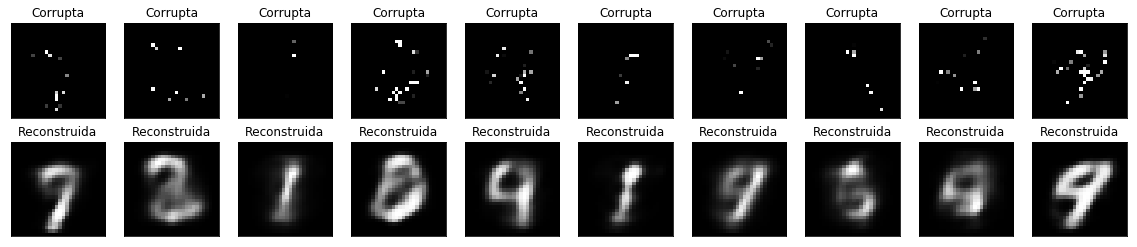

Con p=0.2 : 
Error de reconstrucción=0.161790562057


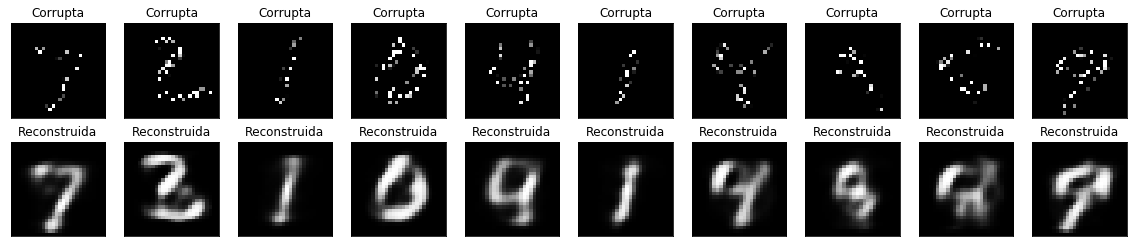

Con p=0.3 : 
Error de reconstrucción=0.147446490669


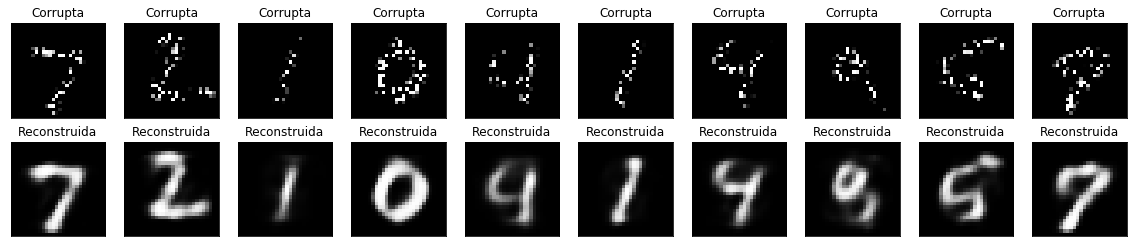

Con p=0.4 : 
Error de reconstrucción=0.13685974741


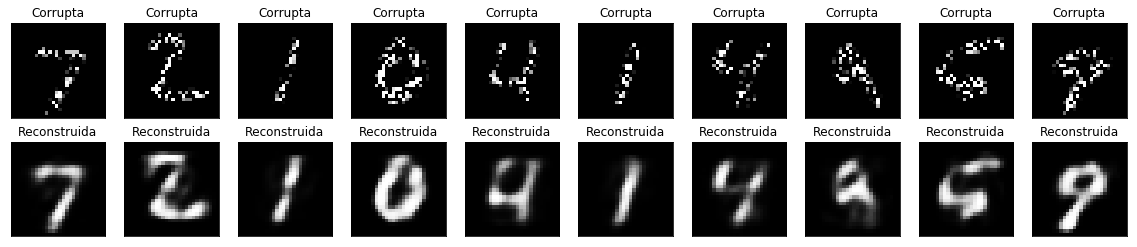

Con p=0.5 : 
Error de reconstrucción=0.12728876766


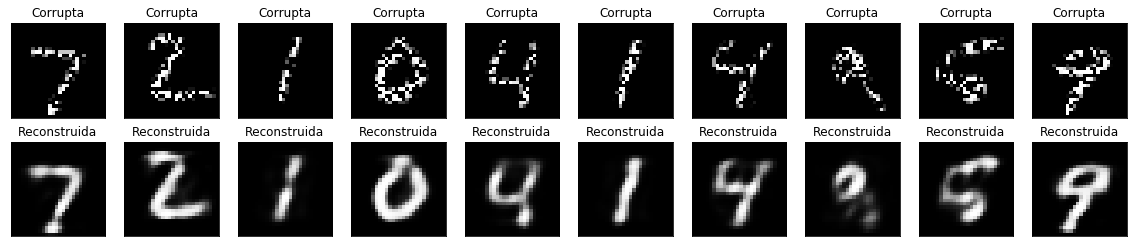

Con p=0.6 : 
Error de reconstrucción=0.119880721486


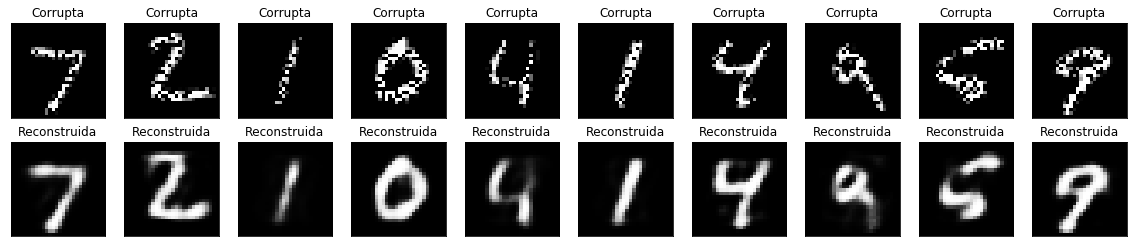

Con p=0.7 : 
Error de reconstrucción=0.112306984043


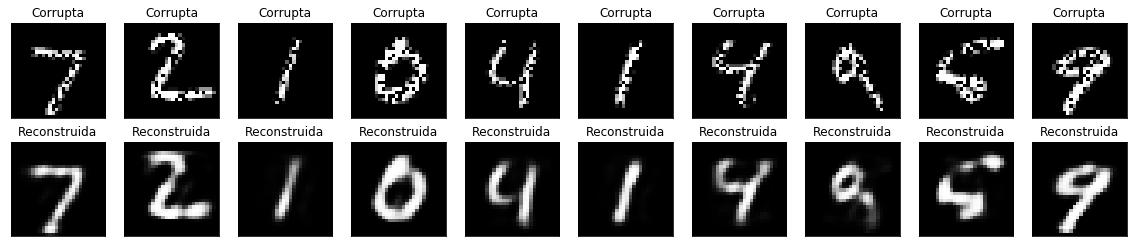

Con p=0.8 : 
Error de reconstrucción=0.106509723508


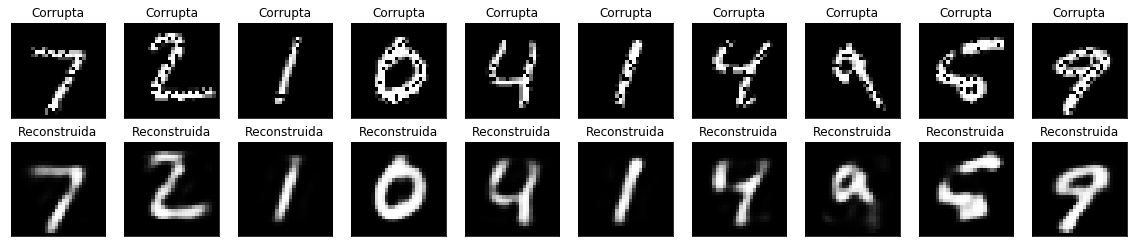

Con p=0.9 : 
Error de reconstrucción=0.0989669345856


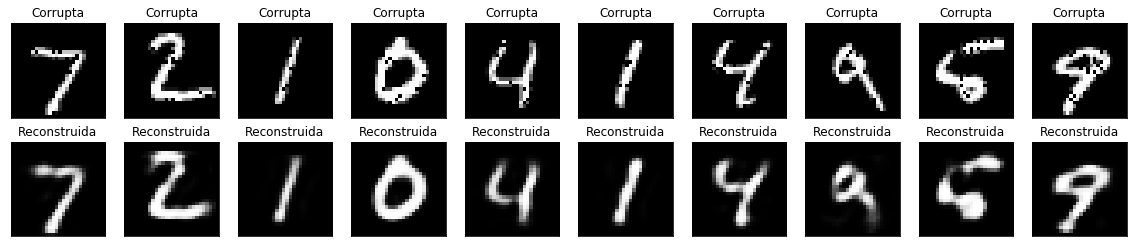

Con p=1.0 : 
Error de reconstrucción=0.092341501832


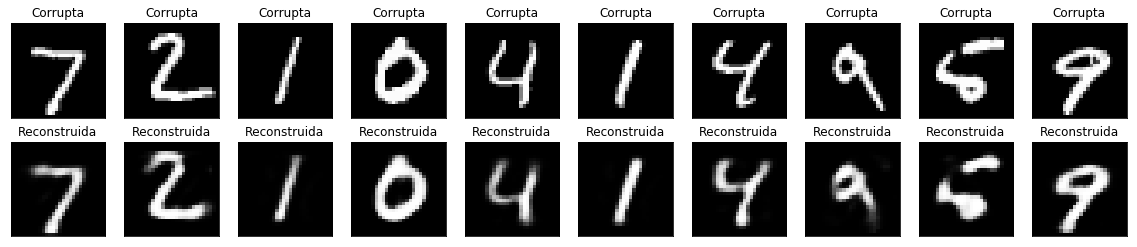

In [11]:
for i in range(1,11):
    noise_level = i/10.0
    autoencoder = load_model('./modelos_entrenados/hadamard_dautoencoder_768x32_p_'+str(noise_level)+'.h5')
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))   
    decoded_shape = Input(shape=(32,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    n = 10
    plt.figure(figsize=(20, 4))
    score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
    print("Con p="+str(noise_level)+" : ")
    print("Error de reconstrucción="+str(score))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
        plt.title("Reconstruida")
    plt.show()

En la celda anterior se presentan 10 ejemplos del dataset con distintos valores de *p*, el cual sería la probabilidad de que un elemento dentro del arreglo que multiplica al original sea 1. Se presenta la versión corrupta y la reconstruida a partir de la representación latente por el autoencoder. Se aprecia cualitativamente la corrupción de la imagen original para los primeros valores de *p*, en donde muchos píxeles son asignados a 0 por lo que existe poca información en la imagen para extraer las características necesarias, por lo que es complejo para el decoder lograr una representación robusta con tan pocos datos, eso se refleja en la reconstrucción de cada imagen y en el error de reconstrucción. A medida que aumenta el valor de *p*, disminuye el error de reconstrucción y mejora la visualización de la imagen reconstruida, esto era lo lógicamente esperado dado que ahora sí el autoencoder tiene más información para extraer los patrones característicos y generar así una buena compresión de la información para luego ser reconstruida. Se aprecia que con un valor de *p* > 0.8 ya es posible identificar los verdaderos números a partir de la reconstrucción de la imagen.  
Con *p* igual a 1 recuperamos el autoencoder clásico, y tenemos la misma reconstrucción que la entregada en para el modelo de la sección anterior (parte a) con relu como función de activación del encoder.

### c) Gaussian Noise

In [12]:
devst = 0.5
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train + noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val + noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test + noise_mask

En la celda anterior, se realiza la corrupción del dataset a través del ruido Gaussiano. Ésta forma de corromper las imágenes es sumándole a cada imagen un arreglo, donde cada componente es independiente a la otra modelada por la distribución Normal con media 0 y desviación estándar 1. Este ruido que se agrega representa a una suma de error con función Normal, lo cual es muy común en varios problemas reales.  
A este ruido se le amplifica por una desviación estándar definida por el usuario, así aumentando o disminuyendo el ruido en la representación corrupta. Esta suma generará una imagen con distintos matices de gris y permitirá ver si el autoencoder es capaz de aprender de manera óptima la reconstrucción del número.

### d) Gaussian Denoising Autoencoder

In [13]:
historiales_gauss = []
for i in range(1,11):
    devst = i/10.0
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train + noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val + noise_mask
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(inputs=input_img, outputs=decoded)
    encoder = Model(inputs=input_img, outputs=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    hist = autoencoder.fit(noisy_x_train, x_train, nb_epoch=40, batch_size=25,
    shuffle=True, validation_data=(noisy_x_val, x_val))
    historiales_gauss.append(hist.history)
    autoencoder.save('./modelos_entrenados/gauss_dautoencoder_768x32_p_'+str(devst)+'.h5')

C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 17s - loss: 0.2237 - val_loss: 0.1718
Epoch 2/40
55000/55000 [==============================] - 16s - loss: 0.1554 - val_loss: 0.1423
Epoch 3/40
55000/55000 [==============================] - 15s - loss: 0.1331 - val_loss: 0.1252
Epoch 4/40
55000/55000 [==============================] - 15s - loss: 0.1200 - val_loss: 0.1159
Epoch 5/40
55000/55000 [==============================] - 17s - loss: 0.1131 - val_loss: 0.1113
Epoch 6/40
55000/55000 [==============================] - 15s - loss: 0.1099 - val_loss: 0.1093
Epoch 7/40
55000/55000 [==============================] - 16s - loss: 0.1081 - val_loss: 0.1076
Epoch 8/40
55000/55000 [==============================] - 17s - loss: 0.1066 - val_loss: 0.1062
Epoch 9/40
55000/55000 [==============================] - 17s - loss: 0.1052 - val_loss: 0.1050
Epoch 10/40
55000/55000 [==============================] - 19s - loss: 0.1041 - val_los

En la celda anterior, se entrena un autoencoder con la misma arquitectura que en el item anterior para reconstruir las imagenes corruptas y con distintos valores de desviación estándar.

Con devst=0.1 : 
Error de reconstrucción=0.0956563446999


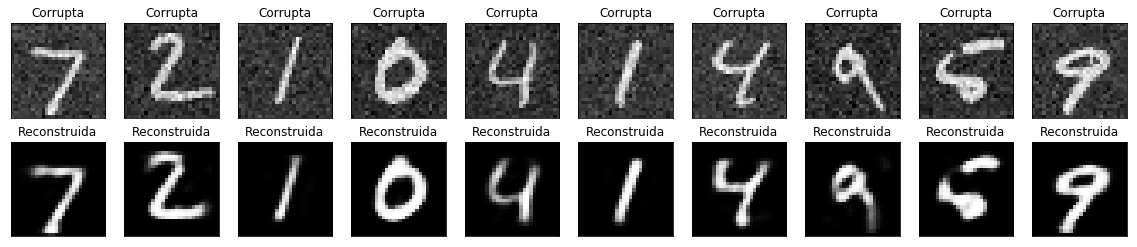

Con devst=0.2 : 
Error de reconstrucción=0.0994188298702


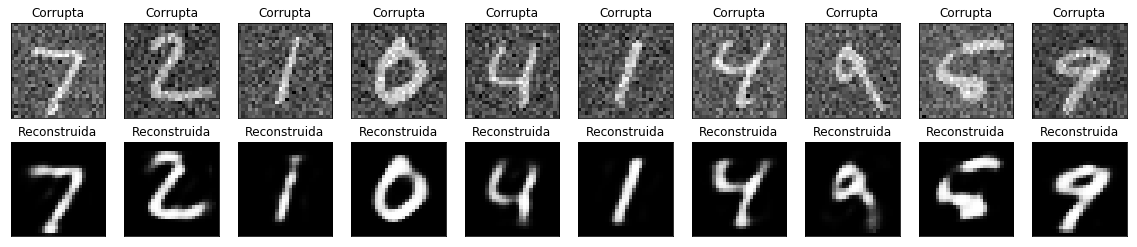

Con devst=0.3 : 
Error de reconstrucción=0.106658231127


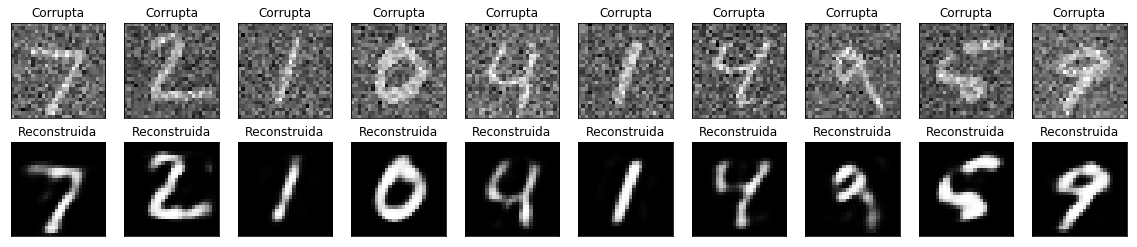

Con devst=0.4 : 
Error de reconstrucción=0.114640114951


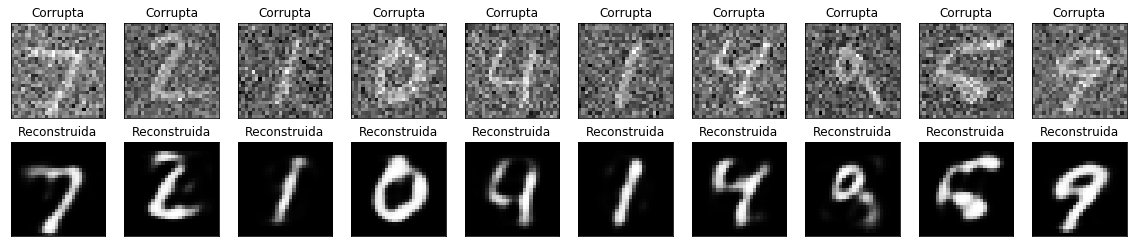

Con devst=0.5 : 
Error de reconstrucción=0.122889405274


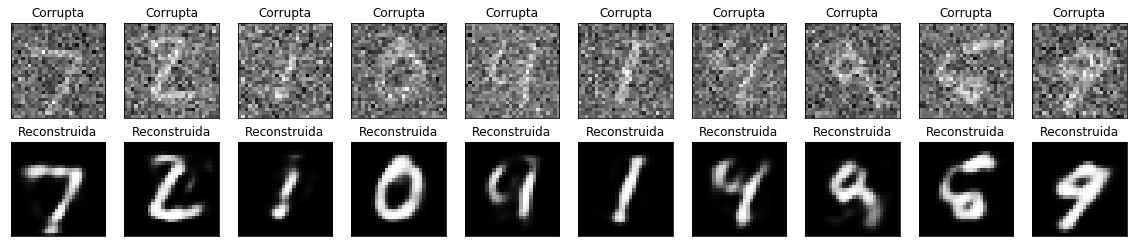

Con devst=0.6 : 
Error de reconstrucción=0.13162522707


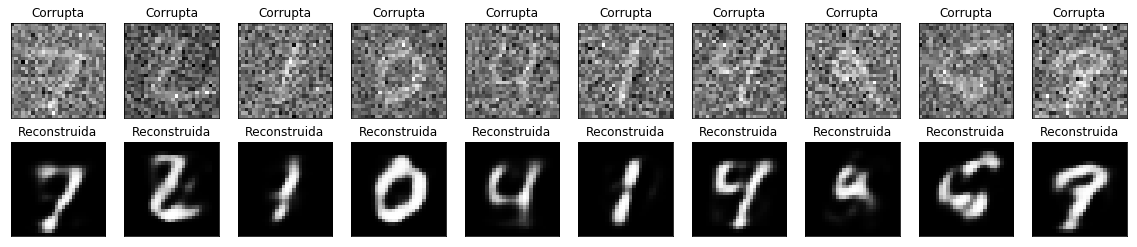

Con devst=0.7 : 
Error de reconstrucción=0.13977962513


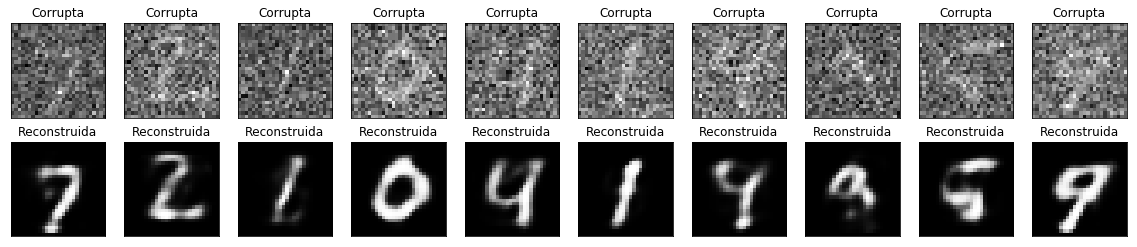

Con devst=0.8 : 
Error de reconstrucción=0.147427841735


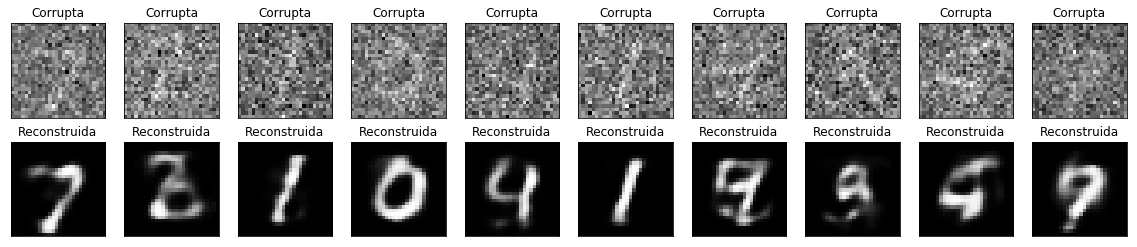

Con devst=0.9 : 
Error de reconstrucción=0.154408893776


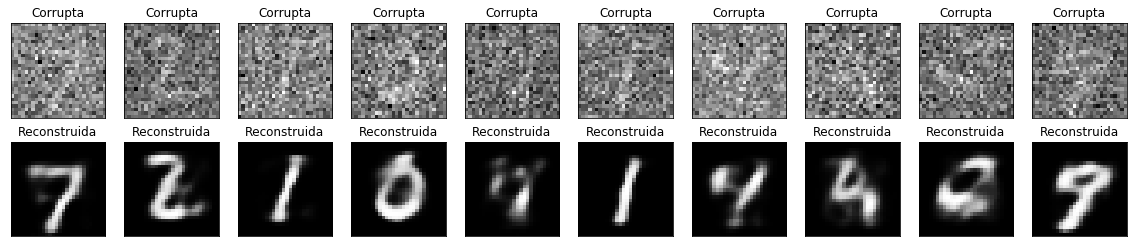

Con devst=1.0 : 
Error de reconstrucción=0.16137849946


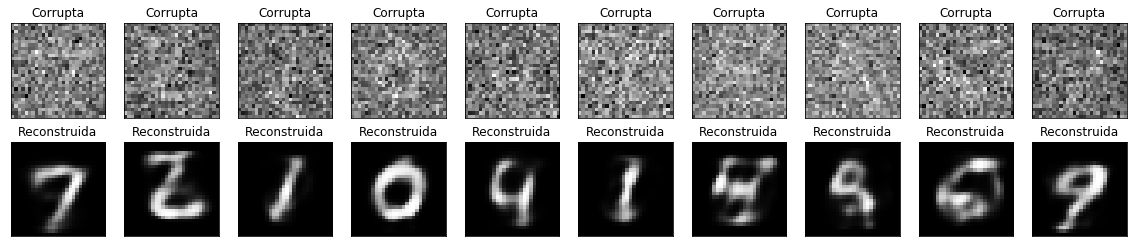

In [14]:
for i in range(1,11):
    devst = i/10.0
    autoencoder = load_model('./modelos_entrenados/gauss_dautoencoder_768x32_p_'+str(devst)+'.h5')
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test + noise_mask
    input_img = autoencoder.input
    encoder_layer = autoencoder.layers[-2]
    encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))   
    decoded_shape = Input(shape=(32,))   
    decoder_layer = autoencoder.layers[-1] 
    decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))    
    encoded_test = encoder.predict(noisy_x_test)
    decoded_test = decoder.predict(encoded_test)
    n = 10
    plt.figure(figsize=(20, 4))
    score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
    print("Con devst="+str(devst)+" : ")
    print("Error de reconstrucción="+str(score))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
    
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
        plt.title("Reconstruida")
    plt.show()

En primer lugar se puede ver en la corrupción que la gran cantidad de píxeles que antes eran 0 (píxel negro) disminuye, debido a que las imágenes originales están en un ambiente bastante ideal donde lo único no nulo es el número que se desea trabajar y detectar. Con esto se puede ver como el ruido gaussiano acerca a los problemas reales ya que los problemas reales nunca están en un ambiente ideal, sino que poseen un ruido tal cual como se ve en las imágenes, teniendo similitud con *ruido blanco*, ya que los números están en un ambiente donde hay píxeles con intensidades similares en distintos puntos de la imagen.  
En la celda anterior se puede apreciar las imagenes corruptas con la respectiva reconstrucción hecha por el autoencoder. Se observa cualitativamente que con una menor desviación estándar la imagen reconstruida se ve mucho más completa y definida en comparación con las imágenes con una alta desviación estándar, las cuales se ven borrosas. Como el grado de dispersión aumenta con la desviación, se pierde la claridad de qué es lo que se necesita reconstruir, por lo que para el autoencoder es más compleja la tarea de descubrir los patrones que tiene que aprender, esto también se presenta a través del error de reconstruir, ya que a medida que la desviación estándar aumenta el error también.

### e) Auto denoising

En esta ocasión definimos un autoencoder con la misma arquitectura que en los últimos items. Ahora bien, se utilizarán las imagenes corruptas en a) hechas por salt-and-pepper y se entrenará el autoencoder para encontrar la mejor representación latente de esa imagen.

In [12]:
noise_level = 0.5
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask

input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(noisy_x_train,x_train, epochs=40, batch_size=25,
    shuffle=True, validation_data=(noisy_x_val, x_val))
autoencoder.save('./modelos_entrenados/pure_dautoencoder_768x32.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 6s - loss: 0.2624 - val_loss: 0.2014
Epoch 2/40
55000/55000 [==============================] - 6s - loss: 0.1889 - val_loss: 0.1914
Epoch 3/40
55000/55000 [==============================] - 6s - loss: 0.1659 - val_loss: 0.1866
Epoch 4/40
55000/55000 [==============================] - 6s - loss: 0.1527 - val_loss: 0.1848
Epoch 5/40
55000/55000 [==============================] - 6s - loss: 0.1456 - val_loss: 0.1835
Epoch 6/40
55000/55000 [==============================] - 6s - loss: 0.1414 - val_loss: 0.1856
Epoch 7/40
55000/55000 [==============================] - 7s - loss: 0.1385 - val_loss: 0.1864
Epoch 8/40
55000/55000 [==============================] - 7s - loss: 0.1365 - val_loss: 0.1844
Epoch 9/40
55000/55000 [==============================] - 6s - loss: 0.1350 - val_loss: 0.1851
Epoch 10/40
55000/55000 [==============================] - 6s - loss: 0.1339 - val_loss: 0.1845


Con p=0.5 : 


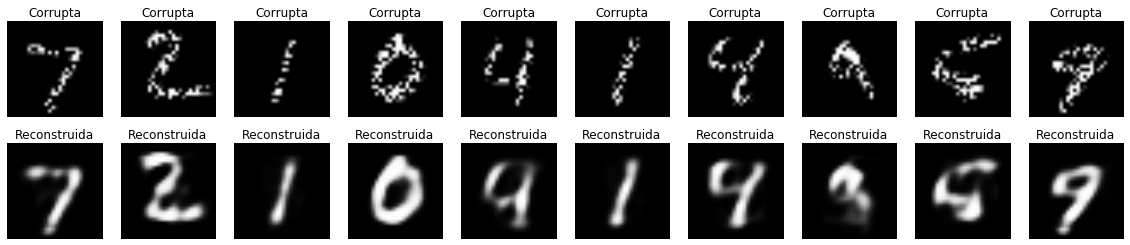

In [13]:
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask
   
encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)
n = 10
plt.figure(figsize=(20, 4))

print("Con p="+str(noise_level)+" : ")
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("Corrupta")
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    plt.title("Reconstruida")
plt.show()

En la imagen anterior se aprecia la reconstrucción a partir de la imagen corrupta con un ruido *salt and pepper* con probabilidad de apagar cada píxel 50%, el cual es el mismo visto anteriormente, la salida del decoder es borrosa y difícil de reconstruir.  
A continuación se evalúa el modelo:

In [14]:
encoded_train = encoder.predict(noisy_x_train)
encoded_test = encoder.predict(noisy_x_test)
score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
print(score)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print('Classification Accuracy K-vecinos %.2f' % clf.score(encoded_test,Y_test))

0.127503674138
Classification Accuracy K-vecinos 0.90


El *accuracy* mediante el clasificador k-NN entrega un valor de 90%, siendo que los autoencoder clásicos trabajando directamente con la representación original obtienen mayor al 90%, esto es ya que el ruido generado con 50% de probabilidad de asignar cada píxel a cero pudo ser muy alto, generando el resultado obtenido en que el autoencoder con denoising empeora. Con esto dicho, se puede ver que el resultado obtenido es bastante alto para un conjunto de ejemplos que están corruptos, es decir, desde ejemplos que vienen en un ambiente no ideal alcanza un *accuracy* bastante bueno.  
Luego de esto se realiza otra experimentación con el generador de ruido gaussiano asignando una desviación estándar de 0.3, entrenando el denoising autoencoder de la misma manera que el modelo anterior.

In [31]:
devst = 0.3
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train + noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val + noise_mask
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=25,
shuffle=True, validation_data=(noisy_x_val, x_val), verbose = 0)
autoencoder.save('./modelos_entrenados/gauss_dautoencoder_768x32_p_'+str(devst)+'.h5')

In [29]:
#cargar y reconstruir modelo
autoencoder = load_model('./modelos_entrenados/gauss_dautoencoder_768x32_p_'+str(devst)+'.h5')
input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))   

#agregar ruido a test
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test + noise_mask

encoded_train = encoder.predict(noisy_x_train)
encoded_test = encoder.predict(noisy_x_test)
score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
print(score)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print('Classification Accuracy K-vecinos %.2f' % clf.score(encoded_test,Y_test))

0.106493683434
Classification Accuracy K-vecinos 0.94


Mediante ruido gaussiano tampoco se logra un *accuracy* que supere el modelo sin denoising, por lo que puede ser por la mala elección de los valores de ruido en ambos modelos, parámetros de desviación estándar y probabilidad de modelo Bernoulli, o bien, esto puede ser ya que el dataset ya viene en un formato "ideal" en el cual no presenta ruido, incluido el conjunto de pruebas, en donde se logran extraer características de una mejor manera a través de la representación original para este caso.  
Lo que se podría necesitar para mejorar el *accuracy* obtenido es agregar mas profundidad a la red, variar la tasa de ruido o cambiar el número de dimensiones en el espacio comprimido, ya que solo se utilizó una compresión a 32 componentes.

## Pre-entrenamiento

En esta parte de la actividad se ve el efecto de pre entrenar los pesos de la red mediante un aprendizaje no supervisado previo, un autoencoder el cual se entrena para extraer carecterísticas relevantes del input que se le presente.

### a) Red clásica FF

In [14]:
model = Sequential()
model.add(Dense(1000, activation='sigmoid', kernel_initializer='uniform', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid', kernel_initializer='uniform'))
model.add(Dense(10, activation='softmax',kernel_initializer='uniform'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
hist_clasico = model.fit(x_train, Y_train,epochs=40, batch_size=128,shuffle=True, validation_data=(x_val, Y_val)) #Originalmente eran 50 epochs
model.save('./modelos_entrenados/Sigmoid-768x1000x1000x10-NFT-50epochs.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_29 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_30 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 9s - loss: 1.9299 - acc: 0.3599 - val_loss: 1.0944 - val_acc: 0.7102
Epoch 2/40
55000/55000 [==============================] - 9s - loss: 0.7697 - acc: 0.7837 - val_loss: 0.4741 - val_acc: 0.8802
Epoch 3/40
55000/55000 [==============================] - 8s - loss: 0.4956 - acc: 0.8553 - v

In [11]:
modelo_clasico = load_model('./modelos_entrenados/Sigmoid-768x1000x1000x10-NFT-50epochs.h5')
score = modelo_clasico.evaluate(x_test,Y_test)
print("\naccuracy:"+str(score[-1]))

 9824/10000 [============================>.] - ETA: 0s
accuracy:0.9427


En primer lugar se entrena una red feed forward clásica sin pre entrenamiento como base para ser comparado con el pre entrenamiento de pesos. Se define una red con dos capas ocultas cada una de 1000 neuronas con función activación sigmoidal y una salida softmax de 10 neuronas, entrenando mediante optimizador clásico SGD con tasa de aprendizaje 0,001 y momentum 0,9.  
Con esta red se obtiene un *accuracy* ** 94,27% ** para la clasificación de los números en la imagen. Este valor es menor que el alcanzado mediante clasificación con k-NN para la representación comprimida del *deep autoencoder* (96%).

### b) Red neuronal pre-entrenando los pesos con autoencoders

En las celdas siguientes se pre-entrenan los pesos de cada capa del modelo definido anteriormente mediante un aprendizaje no supervisado trabajando unicamente con los datos, sin etiquetas. Utilizando el modelo de autoencoder clásico, se espera que estos reconozcan características intrínsecas de la data, así teniendo ya un conocimiento previo de los datos y obtener un mejor resultado.

In [7]:
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_1 = 'sigmoid'
loss_ = 'binary_crossentropy'

#Autoencoder 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=SGD(lr=1), loss=loss_)
autoencoder1.fit(x_train, x_train, epochs=40, batch_size=25, shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('./modelos_entrenados/autoencoder_layer1.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 25s - loss: 0.2364 - val_loss: 0.1992
Epoch 2/40
55000/55000 [==============================] - 25s - loss: 0.1800 - val_loss: 0.1654
Epoch 3/40
55000/55000 [==============================] - 25s - loss: 0.1560 - val_loss: 0.1478
Epoch 4/40
55000/55000 [==============================] - 25s - loss: 0.1416 - val_loss: 0.1360
Epoch 5/40
55000/55000 [==============================] - 25s - loss: 0.1314 - val_loss: 0.1273
Epoch 6/40
55000/55000 [==============================] - 25s - loss: 0.1237 - val_loss: 0.1206
Epoch 7/40
55000/55000 [==============================] - 25s - loss: 0.1177 - val_loss: 0.1153
Epoch 8/40
55000/55000 [==============================] - 25s - loss: 0.1128 - val_loss: 0.1109
Epoch 9/40
55000/55000 [==============================] - 25s - loss: 0.1088 - val_loss: 0.1073
Epoch 10/40
55000/55000 [==============================] - 25s - loss: 0.1054 - val_los

In [8]:
#Autoencoder 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
input_img2 = Input(shape=(1000,))
encoded2 = Dense(1000, activation='sigmoid')(input_img2)
decoded2 = Dense(1000, activation='sigmoid')(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=SGD(lr=1),, loss='binary_crossentropy')
autoencoder2.fit(x_train_encoded1,x_train_encoded1,epochs=40,batch_size=25, shuffle=True, 
                 validation_data=(x_val_encoded1, x_val_encoded1))
autoencoder2.save('./modelos_entrenados/autoencoder_layer2.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 29s - loss: 0.6650 - val_loss: 0.6423
Epoch 2/40
55000/55000 [==============================] - 29s - loss: 0.6257 - val_loss: 0.6129
Epoch 3/40
55000/55000 [==============================] - 29s - loss: 0.6041 - val_loss: 0.5966
Epoch 4/40
55000/55000 [==============================] - 29s - loss: 0.5910 - val_loss: 0.5864
Epoch 5/40
55000/55000 [==============================] - 29s - loss: 0.5825 - val_loss: 0.5796
Epoch 6/40
55000/55000 [==============================] - 29s - loss: 0.5767 - val_loss: 0.5749
Epoch 7/40
55000/55000 [==============================] - 29s - loss: 0.5727 - val_loss: 0.5715
Epoch 8/40
55000/55000 [==============================] - 29s - loss: 0.5699 - val_loss: 0.5691
Epoch 9/40
55000/55000 [==============================] - 29s - loss: 0.5678 - val_loss: 0.5673
Epoch 10/40
55000/55000 [==============================] - 29s - loss: 0.5662 - val_los

Se entrenan los pesos de las dos capas ocultas con un autoencoder, observando que el error de reconstruccion del autoencoder asignado a entrenar los pesos de la segunda capa oculta aumenta considerablemente, esto puede ser ya que el primer autoencoder ya logra extraer las características mas esenciales de la data bruta (input real) en esa arquitectura definida, por lo que el segundo autoencoder debe extraer características para reconstruir el input lo cual le resulta una tarea bastante difícil debido a que la entrada ya fue transformada en una nueva representación que almacena nueva información útil de la data la cual no necesariamente tiene características similares para volver a extraer características relevantes para reconstruir esa nueva representación.
ver si esta bien redactado  

Con el modelo ya pre-entrenado se intenta resolver el problema de clasificar las imágenes con el número que corresponde, asignando los pesos a las capas de la red y entrenando desde ese punto de partida con un entrenamiento previo.

In [6]:
#FineTunning
autoencoder1 = load_model('./modelos_entrenados/autoencoder_layer1.h5')
autoencoder2 = load_model('./modelos_entrenados/autoencoder_layer2.h5')
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(1000, activation='sigmoid'))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
hist_preentrenado = model.fit(x_train, Y_train,epochs=20, batch_size=128, shuffle=True, 
                              validation_data=(x_val, Y_val))
model.save('./modelos_entrenados/Net-768x1000x1000x10-finetunned.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s - loss: 0.5739 - acc: 0.8388 - val_loss: 0.2925 - val_acc: 0.9200
Epoch 2/20
55000/55000 [==============================] - 8s - loss: 0.3401 - acc: 0.9006 - val_loss: 0.2483 - val_acc: 0.9314
Epoch 3/20
55000/55000 [==============================] - 8s - loss: 0.3086 - acc: 0.9093 - v

In [16]:
tunned_modelo_clasico = load_model('./modelos_entrenados/Net-768x1000x1000x10-finetunned.h5')
score = tunned_modelo_clasico.evaluate(x_test,Y_test,verbose=1)
print "\nAccuracy sobre test= ",score[1]

10000/10000 [==============================] - 0s     

Accuracy sobre test=  0.9582


Luego de esta variación en el modelo donde se pre-entrenan los pesos se logra un *accuracy* mayor que el modelo sin pre-entrenar, esto muestra que el realizar un pre-entrenamiento con aprendizaje supervisado logra obtener una ventaja ya que el modelo extrae características no supervisadas de los datos, es decir, reconoce patrones.

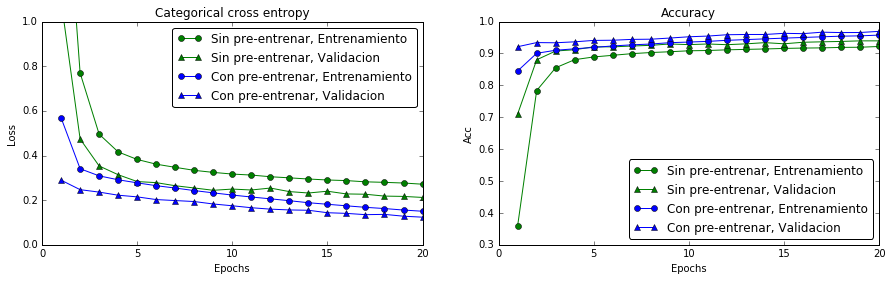

In [37]:
f, axarr = plt.subplots(1,2,figsize=(15,4))

hist1_loss = hist_clasico.history['loss'][:20]
hist1_val = hist_clasico.history['val_loss'][:20]
hist1_acc = hist_clasico.history['acc'][:20]
hist1_val_acc = hist_clasico.history['val_acc'][:20]

hist2_loss = hist_preentrenado.history['loss']
hist2_val = hist_preentrenado.history['val_loss']
hist2_acc = hist_preentrenado.history['acc']
hist2_val_acc = hist_preentrenado.history['val_acc']

epochs1 = range(1, len(hist1_loss) + 1)

axarr[0].plot(epochs1, hist1_loss, 'go-',label = "Sin pre-entrenar, Entrenamiento")
axarr[0].plot(epochs1, hist1_val, 'g^-',label = "Sin pre-entrenar, Validacion")

axarr[0].plot(epochs1, hist2_loss, 'bo-',label = "Con pre-entrenar, Entrenamiento")
axarr[0].plot(epochs1, hist2_val, 'b^-',label = "Con pre-entrenar, Validacion")

axarr[0].set_title('Categorical cross entropy')
axarr[0].set_ylim(0,1)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[0].legend(loc="upper right", fancybox= True)

axarr[1].plot(epochs1, hist1_acc, 'go-',label = "Sin pre-entrenar, Entrenamiento")
axarr[1].plot(epochs1, hist1_val_acc, 'g^-',label = "Sin pre-entrenar, Validacion")

axarr[1].plot(epochs1, hist2_acc, 'bo-',label = "Con pre-entrenar, Entrenamiento")
axarr[1].plot(epochs1, hist2_val_acc, 'b^-',label = "Con pre-entrenar, Validacion")

axarr[1].set_title('Accuracy')
axarr[1].set_ylim(0.3,1)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Acc')

axarr[1].legend(loc="lower right", fancybox= True)
plt.show()

En el gráfico anerior se presentan la función de pérdida *categorical cross entropy* y el *accuracy* para el entrenamiento durante 20 epochs, con color verde la red sin pre-entrenamiento y con color azul la red pre entrenada mediante el aprendizaje no supervisado de autoencoder.  
Se puede ver que el punto de partida de la red con los pesos pre entrenados es mucho mejor, teniendo un valor de pérdida disminuyendo más de la mitad y un *accuracy* inicial casi el doble. Además de este mejor inicio del entrenamiento se puede observar que el desempeño de la red pre entrenada supera al otro durante todos los epochs. Con esto se pudo comprobar experimentalmente que pre entrenar los pesos es una gran ayuda para el modelo gracias a tener una red inicial no definida mediante pesos iniciales aleatorios sino que pesos que ya reconocen características intrínsecas de lo datos... algo mas?

### c) Red neuronal pre-entrenando los pesos con denoising autoencoders

En las siguientes celdas se experimenta el pre-entrenamiento aplicando un denoising autoencoders con ruido gaussiano con desviación estándar de 0.3

In [36]:
devst = 0.3
#corromper la representacion real
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train + noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val + noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test + noise_mask

#Autoencoder 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(1000,activation='sigmoid')(input_img1)
decoded1 = Dense(784, activation='sigmoid')(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=SGD(lr=1),, loss='binary_crossentropy')
autoencoder1.fit(noisy_x_train, x_train, epochs=40, batch_size=25, shuffle=True, 
                 validation_data=(noisy_x_val, x_val))
autoencoder1.save('./modelos_entrenados/dautoencoder_layer1.h5')

x_train_encoded1 = encoder1.predict(noisy_x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(noisy_x_val)
x_test_encoded1 = encoder1.predict(noisy_x_test)
##corromper la representacion comprimida
noise_mask = devst*standard_normal(size=x_train_encoded1.shape)
noisy_x_train_encoded1 = x_train_encoded1 + noise_mask
noise_mask = devst*standard_normal(size=x_val_encoded1.shape)
noisy_x_val_encoded1 = x_val_encoded1 + noise_mask

#Autoencoder 2
input_img2 = Input(shape=(1000,))
encoded2 = Dense(1000, activation='sigmoid')(input_img2)
decoded2 = Dense(1000, activation='sigmoid')(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=SGD(lr=1),, loss='binary_crossentropy')
autoencoder2.fit(noisy_x_train_encoded1,x_train_encoded1,epochs=40,batch_size=25, shuffle=True, 
                 validation_data=(noisy_x_val_encoded1, x_val_encoded1))
autoencoder2.save('./modelos_entrenados/dautoencoder_layer2.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 29s - loss: 0.2383 - val_loss: 0.2020
Epoch 2/40
55000/55000 [==============================] - 29s - loss: 0.1832 - val_loss: 0.1691
Epoch 3/40
55000/55000 [==============================] - 30s - loss: 0.1601 - val_loss: 0.1524
Epoch 4/40
55000/55000 [==============================] - 27s - loss: 0.1465 - val_loss: 0.1414
Epoch 5/40
55000/55000 [==============================] - 28s - loss: 0.1371 - val_loss: 0.1336
Epoch 6/40
55000/55000 [==============================] - 28s - loss: 0.1301 - val_loss: 0.1275
Epoch 7/40
55000/55000 [==============================] - 25s - loss: 0.1247 - val_loss: 0.1228
Epoch 8/40
55000/55000 [==============================] - 25s - loss: 0.1204 - val_loss: 0.1190
Epoch 9/40
55000/55000 [==============================] - 25s - loss: 0.1168 - val_loss: 0.1158
Epoch 10/40
55000/55000 [==============================] - 31s - loss: 0.1139 - val_los

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_12)`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_12)`


Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 33s - loss: 0.6596 - val_loss: 0.6356
Epoch 2/40
55000/55000 [==============================] - 34s - loss: 0.6208 - val_loss: 0.6091
Epoch 3/40
55000/55000 [==============================] - 37s - loss: 0.6015 - val_loss: 0.5945
Epoch 4/40
55000/55000 [==============================] - 35s - loss: 0.5896 - val_loss: 0.5851
Epoch 5/40
55000/55000 [==============================] - 38s - loss: 0.5818 - val_loss: 0.5788
Epoch 6/40
55000/55000 [==============================] - 36s - loss: 0.5764 - val_loss: 0.5744
Epoch 7/40
55000/55000 [==============================] - 32s - loss: 0.5726 - val_loss: 0.5713
Epoch 8/40
55000/55000 [==============================] - 34s - loss: 0.5698 - val_loss: 0.5689
Epoch 9/40
55000/55000 [==============================] - 31s - loss: 0.5677 - val_loss: 0.5672
Epoch 10/40
55000/55000 [==============================] - 33s - loss: 0.5661 - val_los

En el entrenamiento de los pesos de las dos capas de la red feed forward a utilizar para clasificar las imágenes se observa lo mismo acontecido anteriormente de que al entrenamiento de la segunda capa resulta una tarea más dificil debido a que la información ya fue transformada a otro vector que puede no tener características relacionadas entre sí para ser reconstruido mediante un autoencoder.  
En la siguiente celda se crea la red con los pesos ya entrenados a través del aprendizaje no supervisado otorgado por el autoencoder.

In [11]:
#FineTunning
autoencoder1 = load_model('./modelos_entrenados/dautoencoder_layer1.h5')
autoencoder2 = load_model('./modelos_entrenados/dautoencoder_layer2.h5')
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(1000, activation='sigmoid'))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
hist_preentrenado_denosigin = model.fit(noisy_x_train, Y_train,epochs=20, batch_size=128,
 shuffle=True, validation_data=(noisy_x_val, Y_val))
model.save('./modelos_entrenados/SigmoidNet-768x1000x1000x10-dfinetunned.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s - loss: 0.6070 - acc: 0.8277 - val_loss: 0.3374 - val_acc: 0.9094
Epoch 2/20
55000/55000 [==============================] - 8s - loss: 0.3927 - acc: 0.8829 - val_loss: 0.3087 - val_acc: 0.9104
Epoch 3/20
55000/55000 [==============================] - 9s - loss: 0.3635 - acc: 0.8892 - v

In [14]:
model = load_model('./modelos_entrenados/SigmoidNet-768x1000x1000x10-dfinetunned.h5')
score = model.evaluate(noisy_x_test,Y_test)
print "\nAccuracy sobre test= ",score[1]

 9728/10000 [============================>.] - ETA: 0s
Accuracy sobre test=  0.9418


Luego de pre-entrenar esta red con un *denoising autoencoder* se obtiene un desempeño de **94,18%** en *accuracy*, siendo menor que el caso sin denoising, por lo que no se obtiene la mejora que se espera con este método, quizas por la desviación estándar del ruido gaussiano seleccionado, por el tipo de ruido utilizado, o bien, por que la red neuronal sobre el dataset no necesita esto para mejorar.

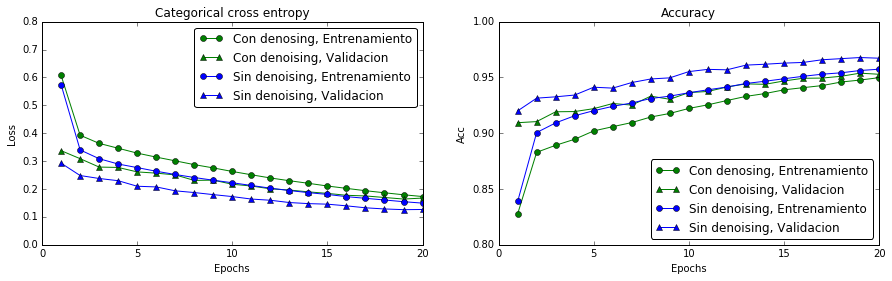

In [13]:
f, axarr = plt.subplots(1,2,figsize=(15,4))

hist1_loss = hist_preentrenado_denosigin.history['loss']
hist1_val = hist_preentrenado_denosigin.history['val_loss']
hist1_acc = hist_preentrenado_denosigin.history['acc']
hist1_val_acc = hist_preentrenado_denosigin.history['val_acc']

hist2_loss = hist_preentrenado.history['loss']
hist2_val = hist_preentrenado.history['val_loss']
hist2_acc = hist_preentrenado.history['acc']
hist2_val_acc = hist_preentrenado.history['val_acc']

epochs1 = range(1, len(hist1_loss) + 1)

axarr[0].plot(epochs1, hist1_loss, 'go-',label = "Con denosing, Entrenamiento")
axarr[0].plot(epochs1, hist1_val, 'g^-',label = "Con denoising, Validacion")

axarr[0].plot(epochs1, hist2_loss, 'bo-',label = "Sin denoising, Entrenamiento")
axarr[0].plot(epochs1, hist2_val, 'b^-',label = "Sin denoising, Validacion")

axarr[0].set_title('Categorical cross entropy')
axarr[0].set_ylim(0,0.8)
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[0].legend(loc="upper right", fancybox= True)

axarr[1].plot(epochs1, hist1_acc, 'go-',label = "Con denosing, Entrenamiento")
axarr[1].plot(epochs1, hist1_val_acc, 'g^-',label = "Con denoising, Validacion")

axarr[1].plot(epochs1, hist2_acc, 'bo-',label = "Sin denoising, Entrenamiento")
axarr[1].plot(epochs1, hist2_val_acc, 'b^-',label = "Sin denoising, Validacion")

axarr[1].set_title('Accuracy')
axarr[1].set_ylim(0.8,1)
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Acc')

axarr[1].legend(loc="lower right", fancybox= True)
plt.show()

En los gráficos anteriores se presentan la evolución de la función de pérdida y el *accuracy* a lo largo del entrenamiento para el modelo sin *denoising* y con *denoising*, donde se observa que el utilizar el modelo sin ruido supera a lo largo de todo el entrenamiento al modelo con ruido, esto para el conjunto de validación y para el de entrenamiento. Con esto se visualiza lo anteriormente dicho de para este problema y con las configuraciones utilizadas el modelo con ruido no logra superar al sin ruido.

### d) Pre-entrenamiento con Relu y Tanh

Se repite el pre-entrenamiento a través del autoencoder básico (sin denoising) cambiando las funciones de activación a Relu y tangente hiperbólica, observando si estos logran pre-entrenar a la red y la posicionan en un buen punto de partida para encontrar una configuración de parámetros con buen desempeño para el problema.

In [3]:
#Relu

#Autoencoder 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(1000,activation='relu')(input_img1)
decoded1 = Dense(784, activation='sigmoid')(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
optimizer_ = SGD(lr=1.0)
autoencoder1.compile(optimizer=SGD(lr=1),, loss="binary_crossentropy")
autoencoder1.fit(x_train, x_train, epochs=40, batch_size=25, shuffle=True, validation_data=(x_val, x_val))
autoencoder1.save('./modelos_entrenados/autoencoder_layer1_relu.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 27s - loss: 0.1750 - val_loss: 0.1253
Epoch 2/40
55000/55000 [==============================] - 26s - loss: 0.1106 - val_loss: 0.0991
Epoch 3/40
55000/55000 [==============================] - 27s - loss: 0.0922 - val_loss: 0.0875
Epoch 4/40
55000/55000 [==============================] - 29s - loss: 0.0838 - val_loss: 0.0819
Epoch 5/40
55000/55000 [==============================] - 29s - loss: 0.0795 - val_loss: 0.0786
Epoch 6/40
55000/55000 [==============================] - 28s - loss: 0.0768 - val_loss: 0.0764
Epoch 7/40
55000/55000 [==============================] - 25s - loss: 0.0750 - val_loss: 0.0749
Epoch 8/40
55000/55000 [==============================] - 25s - loss: 0.0736 - val_loss: 0.0737
Epoch 9/40
55000/55000 [==============================] - 26s - loss: 0.0726 - val_loss: 0.0728
Epoch 10/40
55000/55000 [==============================] - 25s - loss: 0.0717 - val_los

Como la codifiacion es en relu (espacio continuo mayor a 0), el segundo encoder recibe como entrada este input continuo, por lo que se cambia la función de perdida a error cuadrático medio (MSE) y la función del decoder una función suavizada de relu, softplus.

In [44]:
#Autoencoder 2
autoencoder1= load_model('./modelos_entrenados/autoencoder_layer1_relu.h5')
input_img = autoencoder1.input
encoder_layer = autoencoder1.layers[-2]
encoder1 = Model(inputs=input_img, outputs=encoder_layer(input_img))

x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(1000,))
encoded2 = Dense(1000, activation='relu')(input_img2)
decoded2 = Dense(1000, activation='softplus')(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss='mse')
autoencoder2.fit(x_train_encoded1,x_train_encoded1,epochs=40,batch_size=25, shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
autoencoder2.save('./modelos_entrenados/autoencoder_layer2_relu.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 33s - loss: 1.2987 - val_loss: 0.6217
Epoch 2/40
55000/55000 [==============================] - 32s - loss: 0.6444 - val_loss: 0.6287
Epoch 3/40
55000/55000 [==============================] - 32s - loss: 0.6413 - val_loss: 0.6278
Epoch 4/40
55000/55000 [==============================] - 32s - loss: 0.6408 - val_loss: 0.6276
Epoch 5/40
55000/55000 [==============================] - 33s - loss: 0.6406 - val_loss: 0.6276
Epoch 6/40
55000/55000 [==============================] - 32s - loss: 0.6403 - val_loss: 0.6275
Epoch 7/40
55000/55000 [==============================] - 32s - loss: 0.6403 - val_loss: 0.6274
Epoch 8/40
55000/55000 [==============================] - 32s - loss: 0.6399 - val_loss: 0.6273
Epoch 9/40
55000/55000 [==============================] - 32s - loss: 0.5335 - val_loss: 0.4830
Epoch 10/40
55000/55000 [==============================] - 32s - loss: 0.4757 - val_los

In [12]:
autoencoder1 = load_model('./modelos_entrenados/autoencoder_layer1_relu.h5')
autoencoder2 = load_model('./modelos_entrenados/autoencoder_layer2_relu.h5')

model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(1000, activation='relu'))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,epochs=20, batch_size=128, shuffle=True, validation_data=(x_val, Y_val))
model.save('./modelos_entrenados/ReluNet-768x1000x1000x10-finetunned.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_18 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s - loss: 1.2361 - acc: 0.5619 - val_loss: 0.8056 - val_acc: 0.7382
Epoch 2/20
55000/55000 [==============================] - 7s - loss: 0.6422 - acc: 0.8046 - val_loss: 0.4516 - val_acc: 0.8634
Epoch 3/20
55000/55000 [==============================] - 8s - loss: 0.4264 - acc: 0.8743 - v

In [15]:
model = load_model('./modelos_entrenados/ReluNet-768x1000x1000x10-finetunned.h5')
score = model.evaluate(x_test,Y_test)
print "\nAccuracy sobre test= ",score[1]

 9408/10000 [===========================>..] - ETA: 0s
Accuracy sobre test=  0.9742


Con el modelo con funciones de activaciones relu entrenado anteriormente se obtiene un *accuracy* del **97,42%** sobre el conjunto de pruebas, siendo el valor mas alto encontrado hasta el momento, superando el desempeño de k-NN sobre la representación reducida con el *deep autoencoder*, por lo que el pre entrenar utilizando funciones de activaciones *relu* logra obtener un resultado cercano al 100% de *accuracy* sobre el conjunto de pruebas.  

En las siguientes celdas se varía asignando la función de activación tangente hiperbólica (tanh) como encoder y decoder para los dos autoencoder definidos. Como esta función de activación entrega valores continuos entre -1 y 1 es necesario una función de pérdida apropiada, por lo que al igual que con el segundo autoencoder con relu anteriormente se asigna la función de pérdida de error cuadrático medio (MSE).

In [24]:
#tanh

#Autoencoder 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(1000,activation='tanh')(input_img1)
decoded1 = Dense(784, activation='tanh')(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
optimizer_ = SGD(lr=1.0)
autoencoder1.compile(optimizer=SGD(lr=1),, loss="mse")
autoencoder1.fit(x_train, x_train, epochs=40, batch_size=25, shuffle=True, validation_data=(x_val, x_val))
autoencoder1.save('./modelos_entrenados/autoencoder_layer1_tanh.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 30s - loss: 0.0245 - val_loss: 0.0134
Epoch 2/40
55000/55000 [==============================] - 29s - loss: 0.0109 - val_loss: 0.0092
Epoch 3/40
55000/55000 [==============================] - 28s - loss: 0.0082 - val_loss: 0.0074
Epoch 4/40
55000/55000 [==============================] - 27s - loss: 0.0068 - val_loss: 0.0063
Epoch 5/40
55000/55000 [==============================] - 28s - loss: 0.0059 - val_loss: 0.0055
Epoch 6/40
55000/55000 [==============================] - 30s - loss: 0.0052 - val_loss: 0.0050
Epoch 7/40
55000/55000 [==============================] - 29s - loss: 0.0047 - val_loss: 0.0046
Epoch 8/40
55000/55000 [==============================] - 27s - loss: 0.0044 - val_loss: 0.0042
Epoch 9/40
55000/55000 [==============================] - 29s - loss: 0.0041 - val_loss: 0.0039
Epoch 10/40
55000/55000 [==============================] - 28s - loss: 0.0038 - val_los

In [25]:
#Autoencoder 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(1000,))
encoded2 = Dense(1000, activation='tanh')(input_img2)
decoded2 = Dense(1000, activation='tanh')(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=SGD(lr=1),, loss='mse')
autoencoder2.fit(x_train_encoded1,x_train_encoded1,epochs=40,batch_size=25, shuffle=True, 
                 validation_data=(x_val_encoded1, x_val_encoded1))
autoencoder2.save('./modelos_entrenados/autoencoder_layer2_tanh.h5')

Train on 55000 samples, validate on 5000 samples
Epoch 1/40
55000/55000 [==============================] - 34s - loss: 0.0216 - val_loss: 0.0098
Epoch 2/40
55000/55000 [==============================] - 32s - loss: 0.0075 - val_loss: 0.0059
Epoch 3/40
55000/55000 [==============================] - 32s - loss: 0.0050 - val_loss: 0.0043
Epoch 4/40
55000/55000 [==============================] - 34s - loss: 0.0038 - val_loss: 0.0034
Epoch 5/40
55000/55000 [==============================] - 33s - loss: 0.0031 - val_loss: 0.0028
Epoch 6/40
55000/55000 [==============================] - 30s - loss: 0.0026 - val_loss: 0.0024
Epoch 7/40
55000/55000 [==============================] - 33s - loss: 0.0022 - val_loss: 0.0021
Epoch 8/40
55000/55000 [==============================] - 34s - loss: 0.0019 - val_loss: 0.0019
Epoch 9/40
55000/55000 [==============================] - 34s - loss: 0.0017 - val_loss: 0.0017
Epoch 10/40
55000/55000 [==============================] - 32s - loss: 0.0016 - val_los

En el entrenamiento anterior es el único caso en que el segundo autoencoder tiene un error de reconstrucción menor y que disminuye llegando incluso a un valor muy cercano a 0. Esto puede indicar que tangente hiperbólica entrega una codificación del input bastante útil para el problema.

In [8]:
autoencoder1 = load_model('./modelos_entrenados/autoencoder_layer1_tanh.h5')
autoencoder2 = load_model('./modelos_entrenados/autoencoder_layer2_tanh.h5')

model = Sequential()
model.add(Dense(1000, activation='tanh', input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(1000, activation='tanh'))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,epochs=20, batch_size=128, shuffle=True, validation_data=(x_val, Y_val))
model.save('./modelos_entrenados/TanhNet-768x1000x1000x10-finetunned.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 9s - loss: 0.4143 - acc: 0.8823 - val_loss: 0.2428 - val_acc: 0.9322
Epoch 2/20
55000/55000 [==============================] - 8s - loss: 0.2921 - acc: 0.9168 - val_loss: 0.2313 - val_acc: 0.9338
Epoch 3/20
55000/55000 [==============================] - 8s - loss: 0.2667 - acc: 0.9239 - v

In [10]:
model = load_model('./modelos_entrenados/TanhNet-768x1000x1000x10-finetunned.h5')
score = model.evaluate(x_test,Y_test)
print "\nAccuracy sobre test= ",score[1]

 9856/10000 [============================>.] - ETA: 0s
Accuracy sobre test=  0.978


Con el modelo con funciones de activaciones tangente hiperbólica (*tanh*) entrenado anteriormente y pre entrenando los pesos con aprendizaje no supervisado, se obtiene un *accuracy* del **97,8%** sobre el conjunto de pruebas, superando al valor anterior con función de activación relu, pasando a ser el nuevo valor más alto encontrado hasta el momento, por lo que para este problema y la configuración utilizada resultó conveniente utilizar esta función de activación en las capas ocultas.  

Luego de toda la experimentación se ve que cuando se entrena cada capa mediante un aprendizaje no supervisado logra mejorar el entrenamiento ya que los pesos tienen asignados un valor inicial que ya detectan algunas características de algún nivel, las cuales son bastante útiles para la red, esto se ve en el *accuracy* obtenido es mayor en el primer epoch.

## Denoising Autoencoder como generador de datos

In [5]:
x_train.shape

(55000, 784)

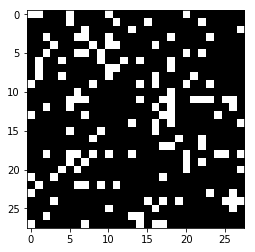

In [54]:
imagen_aleatoria = (np.random.rand(1,784)>=0.85)*1
plt.imshow(imagen_aleatoria.reshape(28,28))
plt.gray()
plt.show()

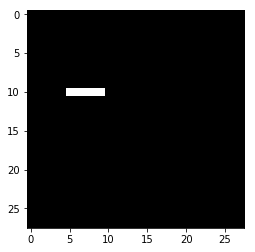

In [51]:
imagen_aleatoria = np.zeros((1,784))
imagen_aleatoria[0,285:290]=1
plt.imshow(imagen_aleatoria.reshape(28,28))
plt.gray()
plt.show()

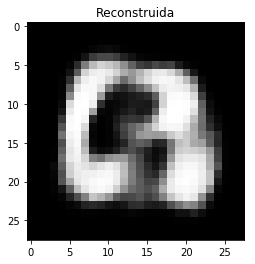

In [55]:
noise_level = 1/10.0
autoencoder = load_model('./modelos_entrenados/hadamard_dautoencoder_768x32_p_0.1.h5')
#autoencoder = load_model('./modelos_entrenados/hadamard_dautoencoder_768x32_p_0.7.h5')

#
#noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
#noisy_x_test = x_test*noise_mask


input_img = autoencoder.input
encoder_layer = autoencoder.layers[-2]
encoder = Model(inputs=input_img, outputs=encoder_layer(input_img))   
decoded_shape = Input(shape=(32,))   
decoder_layer = autoencoder.layers[-1] 
decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))

#encoded_test = encoder.predict(noisy_x_test)
#decoded_test = decoder.predict(encoded_test)

reconstructed_image = autoencoder.predict(imagen_aleatoria)

n = 10
plt.figure(figsize=(20, 4))

plt.imshow(reconstructed_image[0].reshape(28, 28))
plt.gray()
plt.title("Reconstruida")
plt.show()